### Datasets and DataLoaders

In [1]:
# Instalacion de las librerias necesarias
!pip install transformers
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install numpy
!pip install albumentations
!pip install pillow
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install tqdm
!pip install segmentation_models_pytorch

#%pip install sklearn
!pip install scikit-learn

!pip install timm


In [2]:
# --- 1. Librerías Estándar de Python ---
import os
import json
import time
import random
import copy
import math
import multiprocessing
from glob import glob
from pathlib import Path  # Recomendada para rutas en Windows
from typing import List, Tuple, Optional

# --- 2. Procesamiento de Imágenes y Datos ---
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- 3. PyTorch (Core & Neural Networks) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.optim.lr_scheduler import OneCycleLR

# --- 4. Visión por Computadora y Aumentación ---
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp  # La librería clave aquí

# --- 5. Métricas (Scikit-Learn) ---
import sklearn.metrics as metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, mean_squared_error, r2_score
)

# --- 6. Utilidades y Configuración ---
from tqdm import tqdm  # Barra de progreso

# Configuración para imágenes truncadas/corruptas
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Verificación de dispositivo inicial
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Librerías cargadas. Usando dispositivo: {DEVICE}")
if DEVICE.type == 'cpu':
    print(f"Info CPU: {multiprocessing.cpu_count()} núcleos lógicos disponibles.")

c:\Users\pc\Desktop\Proyecto_Segmentacion\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías cargadas. Usando dispositivo: cpu
Info CPU: 8 núcleos lógicos disponibles.


In [3]:


# Rutas
path_csv = "./dataset/labels.csv"
path_save = "./dataset/label_list_clean_with_numeric.csv"

In [4]:
# 1. Carga limpia
df = pd.read_csv(path_csv)

# 2. Limpieza de nombres de columnas
# Es vital quitar espacios y caracteres ocultos (BOM)
df.columns = df.columns.str.strip().str.replace('\ufeff', '')

print(f"Dimensiones iniciales: {df.shape}")

# 3. Definición del Mapeo (Tu lógica es correcta)
mapping = {
    # --- TOPWEAR ---
    "blazer": "topwear", "jacket": "topwear", "coat": "topwear",
    "cape": "topwear", "cardigan": "topwear", "suit": "topwear",
    "t-shirt": "topwear", "shirt": "topwear", "top": "topwear",
    "sweater": "topwear", "hoodie": "topwear", "blouse": "topwear",
    "bodysuit": "topwear", "sweatshirt": "topwear", "vest": "topwear",

    # --- LOWERWEAR ---
    "pants": "lowerwear", "jeans": "lowerwear", "leggings": "lowerwear",
    "skirt": "lowerwear", "shorts": "lowerwear",
    "panties": "lowerwear", "tights": "lowerwear",

    # --- DRESSES ---
    "dress": "dress", "romper": "dress",
    "jumpsuit": "dress", # Sugerencia: Añadir jumpsuit si existe en tu data

    # --- FOOTWEAR ---
    "boots": "footwear", "sneakers": "footwear", "flats": "footwear",
    "heels": "footwear", "loafers": "footwear", "sandals": "footwear",
    "wedges": "footwear", "pumps": "footwear", "clogs": "footwear",
    "shoes": "footwear",

    # --- BODY ---
    "hair": "body", "skin": "body", "face": "body", # Sugerencia: face a veces viene separado

    # --- BACKGROUND ---
    "background": "background",
    "null": "background" # A veces aparece null
}

# 4. Mapeo Numérico
numeric_mapping = {
    "background": 0,
    "topwear": 1,
    "lowerwear": 2,
    "dress": 3,
    "footwear": 4,
    "body": 5,
    "ignore": 255
}

# Aplicar lógica
# Asumimos que la columna 'label_list' contiene el nombre original de la clase
# IMPORTANTE: fillna("ignore") mandará todo lo que no esté en tu lista (gafas, bolsos, joyas) a 255.
df["clean_label"] = df["label_list"].map(mapping).fillna("ignore")
df["numeric_label"] = df["clean_label"].map(numeric_mapping)

# 5. VERIFICACIÓN CRÍTICA (¿Falta algo?)
# Imprimimos qué clases se están yendo a 'ignore' para asegurar que no perdemos ropa importante
ignored_items = df[df["clean_label"] == "ignore"]["label_list"].unique()
print(f"\nItems mapeados a IGNORE (Revisar si falta ropa aquí): \n{ignored_items}")

# 6. Guardar CSV procesado
df.to_csv(path_save, index=False)
print(f"\nArchivo guardado en: {path_save}")

# 7. GENERACIÓN DEL DICCIONARIO DE TRADUCCIÓN (Para usar luego en PyTorch)
# Asumiendo que el índice del DataFrame (0, 1, 2...) corresponde al ID del píxel en la máscara original
# Creamos un diccionario {ID_ORIGINAL : ID_NUEVO}
id_map = df["numeric_label"].to_dict()

print("\nEjemplo de diccionario de traducción para el Dataset:")
print(dict(list(id_map.items())[:10]))



Dimensiones iniciales: (59, 2)

Items mapeados a IGNORE (Revisar si falta ropa aquí): 
['accessories' 'bag' 'belt' 'bra' 'bracelet' 'earrings' 'glasses' 'gloves'
 'hat' 'intimate' 'jumper' 'necklace' 'purse' 'ring' 'scarf' 'socks'
 'stockings' 'sunglasses' 'swimwear' 'tie' 'wallet' 'watch']

Archivo guardado en: ./dataset/label_list_clean_with_numeric.csv

Ejemplo de diccionario de traducción para el Dataset:
{0: 0, 1: 255, 2: 255, 3: 255, 4: 1, 5: 1, 6: 1, 7: 4, 8: 255, 9: 255}


In [5]:

df

Unnamed: 0   label_list clean_label  numeric_label
0            0   background  background              0
1            1  accessories      ignore            255
2            2          bag      ignore            255
3            3         belt      ignore            255
4            4       blazer     topwear              1
5            5       blouse     topwear              1
6            6     bodysuit     topwear              1
7            7        boots    footwear              4
8            8          bra      ignore            255
9            9     bracelet      ignore            255
10          10         cape     topwear              1
11          11     cardigan     topwear              1
12          12        clogs    footwear              4
13          13         coat     topwear              1
14          14        dress       dress              3
15          15     earrings      ignore            255
16          16        flats    footwear              4
17          17      glasses      ignore            255
18          18       gloves      ignore            255
19          19         hair        body              5
20          20          hat      ignore            255
21          21        heels    footwear              4
22          22       hoodie     topwear              1
23          23     intimate      ignore            255
24          24       jacket     topwear              1
25          25        jeans   lowerwear              2
26          26       jumper      ignore            255
27          27     leggings   lowerwear              2
28          28      loafers    footwear              4
29          29     necklace      ignore            255
30          30      panties   lowerwear              2
31          31        pants   lowerwear              2
32          32        pumps    footwear              4
33          33        purse      ignore            255
34          34         ring      ignore            255
35          35       romper       dress              3
36          36      sandals    footwear              4
37          37        scarf      ignore            255
38          38        shirt     topwear              1
39          39        shoes    footwear              4
40          40       shorts   lowerwear              2
41          41         skin        body              5
42          42        skirt   lowerwear              2
43          43     sneakers    footwear              4
44          44        socks      ignore            255
45          45    stockings      ignore            255
46          46         suit     topwear              1
47          47   sunglasses      ignore            255
48          48      sweater     topwear              1
49          49   sweatshirt     topwear              1
50          50     swimwear      ignore            255
51          51      t-shirt     topwear              1
52          52          tie      ignore            255
53          53       tights   lowerwear              2
54          54          top     topwear              1
55          55         vest     topwear              1
56          56       wallet      ignore            255
57          57        watch      ignore            255
58          58       wedges    footwear              4

In [16]:
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

TARGET_SIZE = 512
CANVAS_SIZE = 640 # Considera subir esto si tus imágenes originales son muy grandes

train_tf = A.Compose([
    # -----------------------------------------------------------------------
    # 1. BLOQUE GEOMÉTRICO (Solución al sesgo de escala)
    # -----------------------------------------------------------------------
    A.LongestMaxSize(max_size=CANVAS_SIZE, p=1.0),
    
    A.PadIfNeeded(
        min_height=CANVAS_SIZE, min_width=CANVAS_SIZE,
        border_mode=cv2.BORDER_REFLECT, value=0, mask_value=255, p=1.0
    ),
    
    # ### CRÍTICO 1: Aumentamos drásticamente el rango de escala.
    # De -0.5 a 0.5 permite que la imagen sea la MITAD de su tamaño (simulando lejanía)
    # o 1.5 veces más grande (simulando primerísimos planos).
    A.ShiftScaleRotate(
        shift_limit=0.1,      # Reducimos shift para no sacar la imagen del cuadro al achicarla
        scale_limit=(-0.6, 0.5), # Rango agresivo: 40% a 150% del tamaño
        rotate_limit=15,
        border_mode=cv2.BORDER_REFLECT, value=0, mask_value=255, 
        p=0.9
    ),
    
    # ### CRÍTICO 2: SafeRandomCrop (o RandomCrop inteligente)
    # A veces NO deberíamos recortar si la imagen ya es pequeña por el escalado.
    # Pero para mantener consistencia de tensor, mantenemos el Crop, pero
    # asegurate de que el TARGET_SIZE no sea mayor que lo que queda de imagen tras el escalado.
    A.RandomCrop(height=TARGET_SIZE, width=TARGET_SIZE, p=1.0),

    # -----------------------------------------------------------------------
    # 2. SIMULACIÓN DE LEJANÍA (PÉRDIDA DE INFORMACIÓN)
    # -----------------------------------------------------------------------
    # ### CRÍTICO 3: Esto enseña a la red a segmentar "manchas" sin textura definida.
    A.OneOf([
        # Downscale reduce la calidad simulando que el objeto está lejos y tiene pocos píxeles reales.
        A.Downscale(scale_min=0.25, scale_max=0.5, p=1.0), 
        
        # Mantenemos tus blurs, pero con menos probabilidad si usamos Downscale
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
    ], p=0.3), # 30% de las veces la imagen será de "mala calidad/lejana"

    # -----------------------------------------------------------------------
    # 3. BLOQUE DE DIVERSIDAD CORPORAL (Tu bloque original, está bien)
    # -----------------------------------------------------------------------
    A.OneOf([
        A.OpticalDistortion(distort_limit=0.5, shift_limit=0.2, border_mode=0, value=0, mask_value=255, p=1.0),
        A.GridDistortion(num_steps=7, distort_limit=0.4, border_mode=0, value=0, mask_value=255, p=1.0),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=40, border_mode=0, value=0, mask_value=255, p=1.0)
    ], p=0.5), # Bajamos un poco la probabilidad para priorizar la geometría simple a veces

    A.HorizontalFlip(p=0.5),

    # -----------------------------------------------------------------------
    # 4. COLOR Y TEXTURA (Tu bloque original)
    # -----------------------------------------------------------------------
    A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.3),
    ], p=0.6),

    # -----------------------------------------------------------------------
    # 5. ROBUSTEZ (Tu bloque original)
    # -----------------------------------------------------------------------
    # Ruido gaussiano movido aquí para afectar a la imagen ya escalada/distorsionada
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.2), 
    
    A.CoarseDropout(
        max_holes=8, max_height=32, max_width=32, min_holes=2, 
        fill_value=0, mask_fill_value=255, p=0.3
    ),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_tf = A.Compose([
    A.LongestMaxSize(max_size=TARGET_SIZE, p=1.0),
    A.PadIfNeeded(
        min_height=TARGET_SIZE, min_width=TARGET_SIZE,
        border_mode=cv2.BORDER_REFLECT, value=0, mask_value=255, p=1.0
    ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

C:\Users\pc\AppData\Local\Temp\ipykernel_40484\1284170766.py:14: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
C:\Users\pc\AppData\Local\Temp\ipykernel_40484\1284170766.py:22: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
C:\Users\pc\AppData\Local\Temp\ipykernel_40484\1284170766.py:42: UserWarning: Argument(s) 'scale_min, scale_max' are not valid for transform Downscale
  A.Downscale(scale_min=0.25, scale_max=0.5, p=1.0),
C:\Users\pc\AppData\Local\Temp\ipykernel_40484\1284170766.py:52: UserWarning: Argument(s) 'shift_limit, value, mask_value' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.5, shift_limit=0.2, border_mode=0, value=0, mask_value=255, p=1.0),
C:\Users\pc\AppData\Local\Temp\ipykernel_40484\1284170766.py:53: UserWarning: Argument(s) 'value, mask_value' are not valid for transform GridDistortion
  A.GridDistortion(num_s

In [17]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, root, csv_labels_path, transformations=None):
        """
        Args:
            root (str): Ruta raíz donde están las carpetas 'png_images' y 'png_masks'.
            csv_labels_path (str): Ruta al CSV que generamos anteriormente.
            transformations (albumentations.Compose): Pipeline de augmentación.
        """
        # 1. Rutas de Archivos
        self.im_paths = sorted(glob(os.path.join(root, "png_images", "IMAGES", "*.png")))
        self.gt_paths = sorted(glob(os.path.join(root, "png_masks", "MASKS", "*.png")))

        # Verificación de integridad
        assert len(self.im_paths) > 0, "No se encontraron imágenes. Revisa la ruta."
        assert len(self.im_paths) == len(self.gt_paths), \
            f"Desajuste: {len(self.im_paths)} imágenes vs {len(self.gt_paths)} máscaras."

        self.transformations = transformations
        self.ignore_index = 255

        # 2. Carga y Procesamiento del CSV (Local, no global)
        df = pd.read_csv(csv_labels_path)

        # Asumimos que el índice del CSV corresponde al valor del pixel original (0, 1, 2...)
        # Si tu CSV tiene una columna explícita de ID original, úsala en lugar de df.index

        # Creamos la LUT (Lookup Table) para mapeo INSTANTÁNEO
        # Suponemos que el valor máximo de pixel original no supera 255 (uint8)
        # Si supera 255, aumentamos el tamaño, pero en máscaras PNG suele ser 8-bit.
        max_original_id = 256
        self.mapping_array = np.full(max_original_id, self.ignore_index, dtype=np.uint8)

        # Llenamos la tabla: mapping_array[id_original] = id_nuevo
        # Asumiendo que el orden del CSV es el ID original (0, 1, 2...)
        # Si 'numeric_label' es tu columna destino:
        for idx, row in df.iterrows():
            if idx < max_original_id:
                self.mapping_array[idx] = row['numeric_label']

        # 3. Metadatos de Clases (para visualización/métricas)
        # Filtramos solo las clases que NO son ignore
        valid_classes = df[df['numeric_label'] != self.ignore_index]

        # Creamos diccionario {ID_NUEVO: NOMBRE_CLASE} para decodificar
        # Usamos drop_duplicates para quedarnos con un nombre por ID numérico
        self.idx_to_label = valid_classes.drop_duplicates(subset=['numeric_label']).set_index('numeric_label')['clean_label'].to_dict()

        self.n_cls = len(self.idx_to_label)

        print(f"Dataset cargado: {len(self.im_paths)} imágenes.")
        print(f"Clases detectadas ({self.n_cls}): {self.idx_to_label}")

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        # 1. Cargar Imagen
        try:
            im = np.array(Image.open(self.im_paths[idx]).convert("RGB"))
            gt = np.array(Image.open(self.gt_paths[idx]))
        except Exception as e:
            # MEJORA: Si falla, intenta con otro aleatorio, no siempre el 0
            new_idx = np.random.randint(0, len(self.im_paths))
            return self.__getitem__(new_idx)

        # 2. Mapeo Vectorizado (Optimización Clave )
        # En vez del bucle for, usamos indexing de numpy.
        # self.mapping_array[gt] reemplaza cada pixel de 'gt' por el valor en esa posición del array.
        # Ejemplo: si gt tiene un pixel con valor 4, busca mapping_array[4] -> devuelve 1 (topwear)

        # Aseguramos que gt no tenga valores fuera de rango (ruido)
        gt = np.clip(gt, 0, 255)

        # La magia ocurre aquí:
        gt_remapped = self.mapping_array[gt]

        # 3. Augmentación (Albumentations)
        if self.transformations:
            augmented = self.transformations(image=im, mask=gt_remapped)
            im = augmented["image"]
            gt = augmented["mask"]
        else:
            # Si no hay transformaciones, convertimos a tensores manualmente
            im = torch.from_numpy(im).float().permute(2, 0, 1) / 255.0
            gt = torch.from_numpy(gt_remapped).long()

        # 4. Verificaciones de Tipo Finales
        # Albumentations con ToTensorV2 ya devuelve Tensores, pero nos aseguramos del tipo
        if not isinstance(im, torch.Tensor):
            im = torch.from_numpy(im).float().permute(2, 0, 1) / 255.0

        if not isinstance(gt, torch.Tensor):
            gt = torch.from_numpy(gt).long()

        # Asegurar long para la máscara (requerido por CrossEntropyLoss)
        gt = gt.long()

        return im, gt

    def get_class_names(self):
        """Retorna los nombres de las clases ordenados por índice"""
        return [self.idx_to_label[i] for i in range(self.n_cls) if i in self.idx_to_label]

In [18]:
def get_dls(
    root,
    train_tf,
    val_tf,
    bs,
    split=(0.8, 0.1, 0.1),
    csv_labels_path=None,
    seed=42,
    device="cpu"  # <--- CAMBIO 1: Por defecto CPU para local
):
    """
    Crea DataLoaders optimizados para ejecución Local en Windows (CPU).
    """

    # -----------------------------------------------------------
    # 1. Configuración de Hardware (Ajuste crítico para Windows/i5)
    # -----------------------------------------------------------
    # En Windows + CPU, usar muchos workers causa overhead excesivo.
    # '0' workers corre en el hilo principal: es lo más rápido para debug
    # y evita errores de 'BrokenPipeError'.
    if os.name == 'nt': # Detecta si es Windows
        ns = 0  # Recomendado 0 para empezar. Máximo 2 si todo va bien.
    else:
        ns = 0  # Linux/Mac pueden manejar un poco más

    print(f" Configuración: Device={device}, Workers={ns}, Batch Size={bs}")

    # -----------------------------------------------------------
    # 2. Dataset Base (Solo para obtener índices y metadatos)
    # -----------------------------------------------------------
    # Instanciamos una vez sin transformaciones para calcular los splits
    base_ds = CustomSegmentationDataset(
        root=root,
        csv_labels_path=csv_labels_path,
        transformations=None
    )

    dataset_info = {
        'n_cls': base_ds.n_cls,
        'ignore_index': base_ds.ignore_index,
        'class_names': base_ds.get_class_names(),
        # Asumiendo que idx_to_label existe en tu dataset
        'label_to_idx': getattr(base_ds, 'idx_to_label', {}) 
    }

    print(f"\nResumen del Dataset:")
    print(f"Total imágenes: {len(base_ds)}")
    
    # -----------------------------------------------------------
    # 3. Splitting (División de Índices)
    # -----------------------------------------------------------
    generator = torch.Generator().manual_seed(seed)

    total_len = len(base_ds)
    tr_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - tr_len - val_len

    indices = torch.randperm(total_len, generator=generator)

    tr_idx = indices[:tr_len]
    val_idx = indices[tr_len:tr_len + val_len]
    test_idx = indices[tr_len + val_len:]

    print(f"\nDivisión (Seed={seed}):")
    print(f"Train: {len(tr_idx)} | Val: {len(val_idx)} | Test: {len(test_idx)}")

    # -----------------------------------------------------------
    # 4. Creación de Subsets
    # -----------------------------------------------------------
    # Creamos nuevas instancias para asignar las transformaciones correctas
    train_ds = Subset(
        CustomSegmentationDataset(root, csv_labels_path, transformations=train_tf),
        tr_idx
    )
    val_ds = Subset(
        CustomSegmentationDataset(root, csv_labels_path, transformations=val_tf),
        val_idx
    )
    test_ds = Subset(
        CustomSegmentationDataset(root, csv_labels_path, transformations=val_tf),
        test_idx
    )

    # -----------------------------------------------------------
    # 5. DataLoaders (Tuning para CPU Local)
    # -----------------------------------------------------------
    # pin_memory: True es útil si vas a mover datos a GPU. 
    # Si entrenas en CPU pura, False ahorra RAM y evita paginación innecesaria.
    use_pin = True if device == "cuda" else False
    
    # prefetch_factor: Debe ser None si num_workers es 0
    prefetch = 2 if ns > 0 else None
    
    # persistent_workers: Mantiene los procesos vivos. 
    # Solo usar si ns > 0, si no, da error.
    persist = (ns > 0)

    tr_dl = DataLoader(
        train_ds,
        batch_size=bs,
        shuffle=True,
        num_workers=ns,
        pin_memory=use_pin,
        persistent_workers=persist,
        prefetch_factor=prefetch
    )

    val_dl = DataLoader(
        val_ds,
        batch_size=bs,
        shuffle=False,
        num_workers=ns,
        pin_memory=use_pin,
        persistent_workers=persist,
        prefetch_factor=prefetch
    )

    test_dl = DataLoader(
        test_ds,
        batch_size=1, # Mantener en 1 para test visual
        shuffle=False,
        num_workers=ns,
        pin_memory=use_pin,
        persistent_workers=persist
    )

    # -----------------------------------------------------------
    # 6. Verificación Rápida
    # -----------------------------------------------------------
    def check_dist(loader, name):
        try:
            # next(iter()) carga el primer batch real
            imgs, masks = next(iter(loader))
            unique, counts = torch.unique(masks, return_counts=True)
            dist = dict(zip(unique.numpy(), counts.numpy()))
            print(f"Verificación {name} OK. Shape imgs: {imgs.shape}")
        except Exception as e:
            print(f"⚠️ Error verificando {name}: {e}")
            # En Windows esto suele pasar si no se protege el main loop

    print("\nVerificación de carga de datos:")
    check_dist(tr_dl, "Train")

    return tr_dl, val_dl, test_dl, dataset_info

In [19]:
device = "cpu" 
print(f"Usando dispositivo: {device}")


# Define the root path based on the existing path_csv
root = "dataset"
path_save =  r"dataset\label_list_clean_with_numeric.csv"

# Llamada corregida
tr_dl, val_dl, test_dl, info = get_dls(
    root=root,
    train_tf=train_tf,
    val_tf=val_tf,
    bs=4,                       # Reducido a 8 para reducir uso de RAM
    #ns=0,                      #<-- BORRAR ESTA LÍNEA (la función ya lo calcula óptimo)
    csv_labels_path=path_save,
    device=device
)

# Verificación rápida
print(f"Clases detectadas: {info['n_cls']}")

Usando dispositivo: cpu
 Configuración: Device=cpu, Workers=0, Batch Size=4
Dataset cargado: 1000 imágenes.
Clases detectadas (6): {0: 'background', 1: 'topwear', 4: 'footwear', 3: 'dress', 5: 'body', 2: 'lowerwear'}

Resumen del Dataset:
Total imágenes: 1000

División (Seed=42):
Train: 800 | Val: 100 | Test: 100
Dataset cargado: 1000 imágenes.
Clases detectadas (6): {0: 'background', 1: 'topwear', 4: 'footwear', 3: 'dress', 5: 'body', 2: 'lowerwear'}
Dataset cargado: 1000 imágenes.
Clases detectadas (6): {0: 'background', 1: 'topwear', 4: 'footwear', 3: 'dress', 5: 'body', 2: 'lowerwear'}
Dataset cargado: 1000 imágenes.
Clases detectadas (6): {0: 'background', 1: 'topwear', 4: 'footwear', 3: 'dress', 5: 'body', 2: 'lowerwear'}

Verificación de carga de datos:
Verificación Train OK. Shape imgs: torch.Size([4, 3, 512, 512])
Clases detectadas: 6


## VISUALIZACION DE LA DATA




 Visualizando DATASET (6 muestras)...


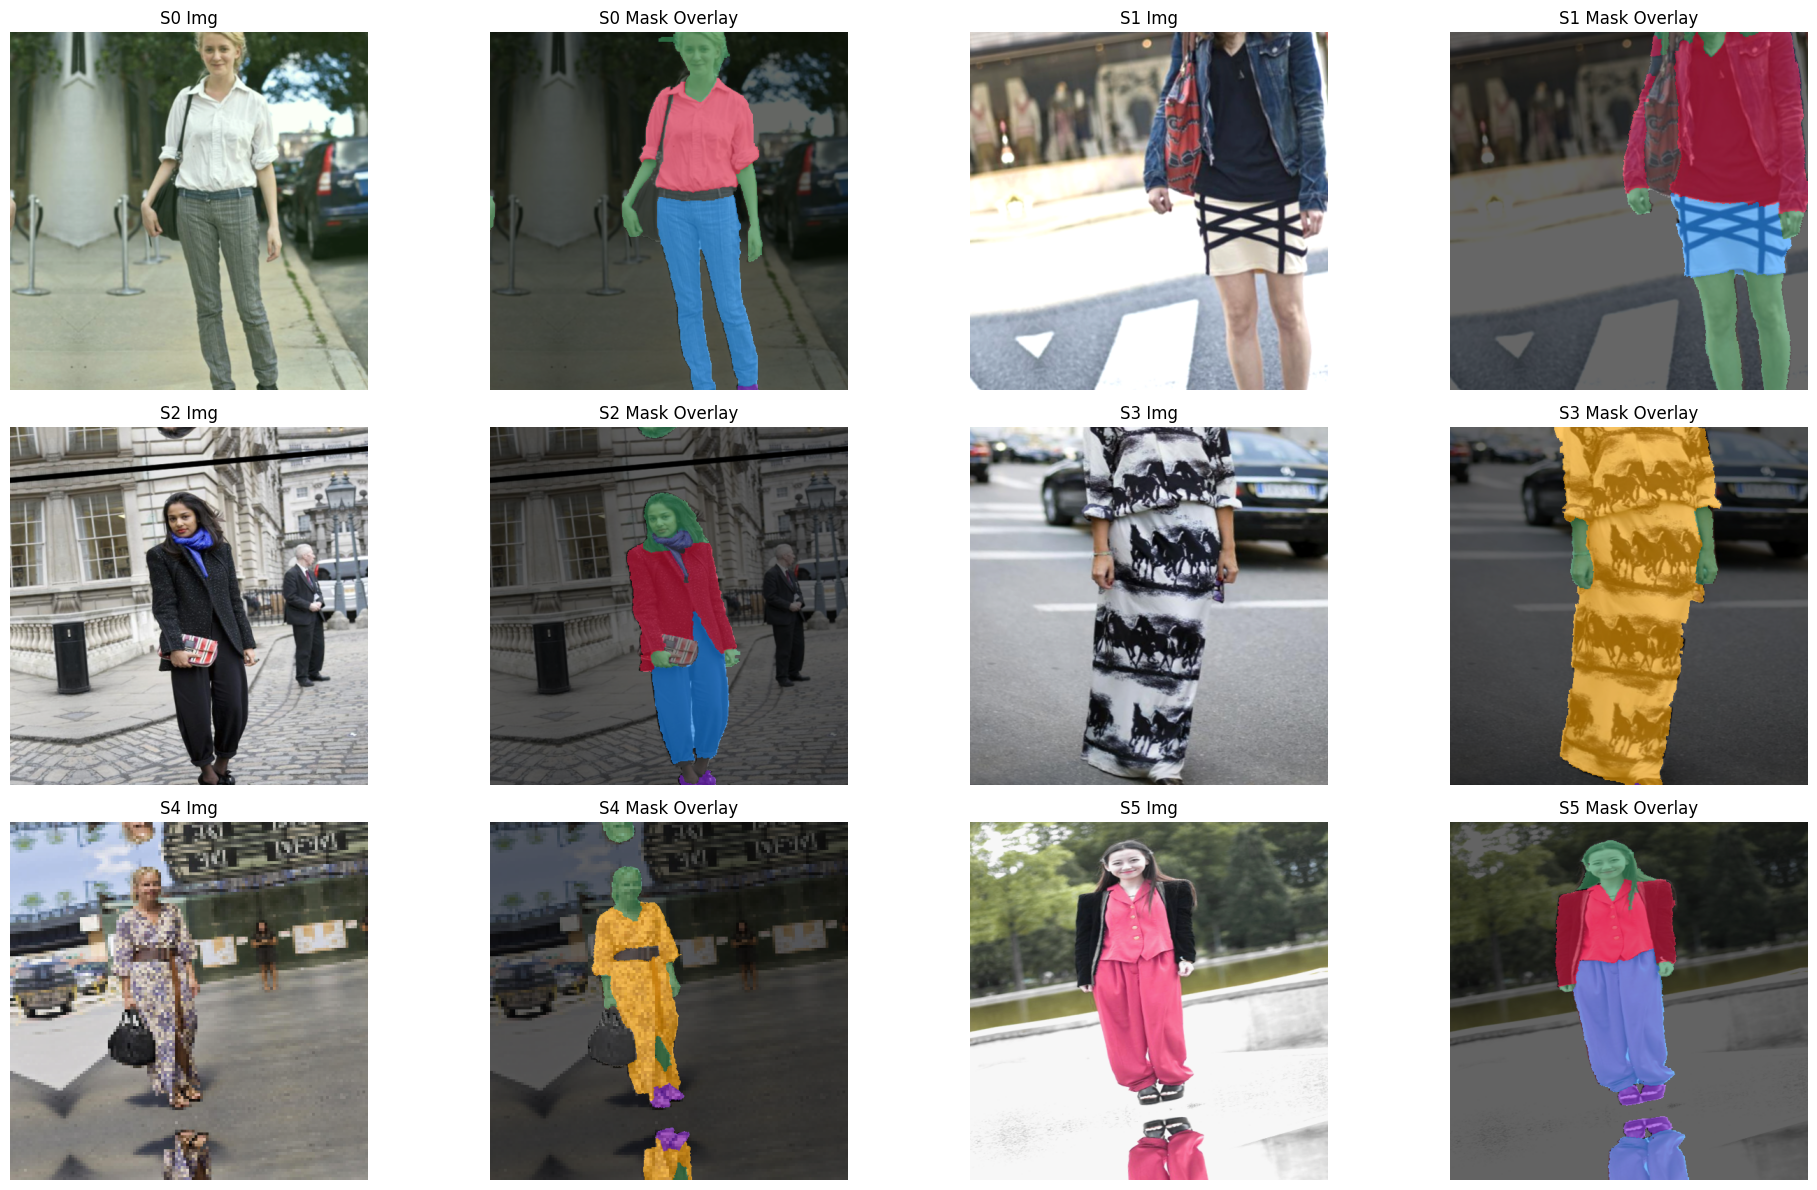



 Visualizando DATALOADER (4 muestras)...


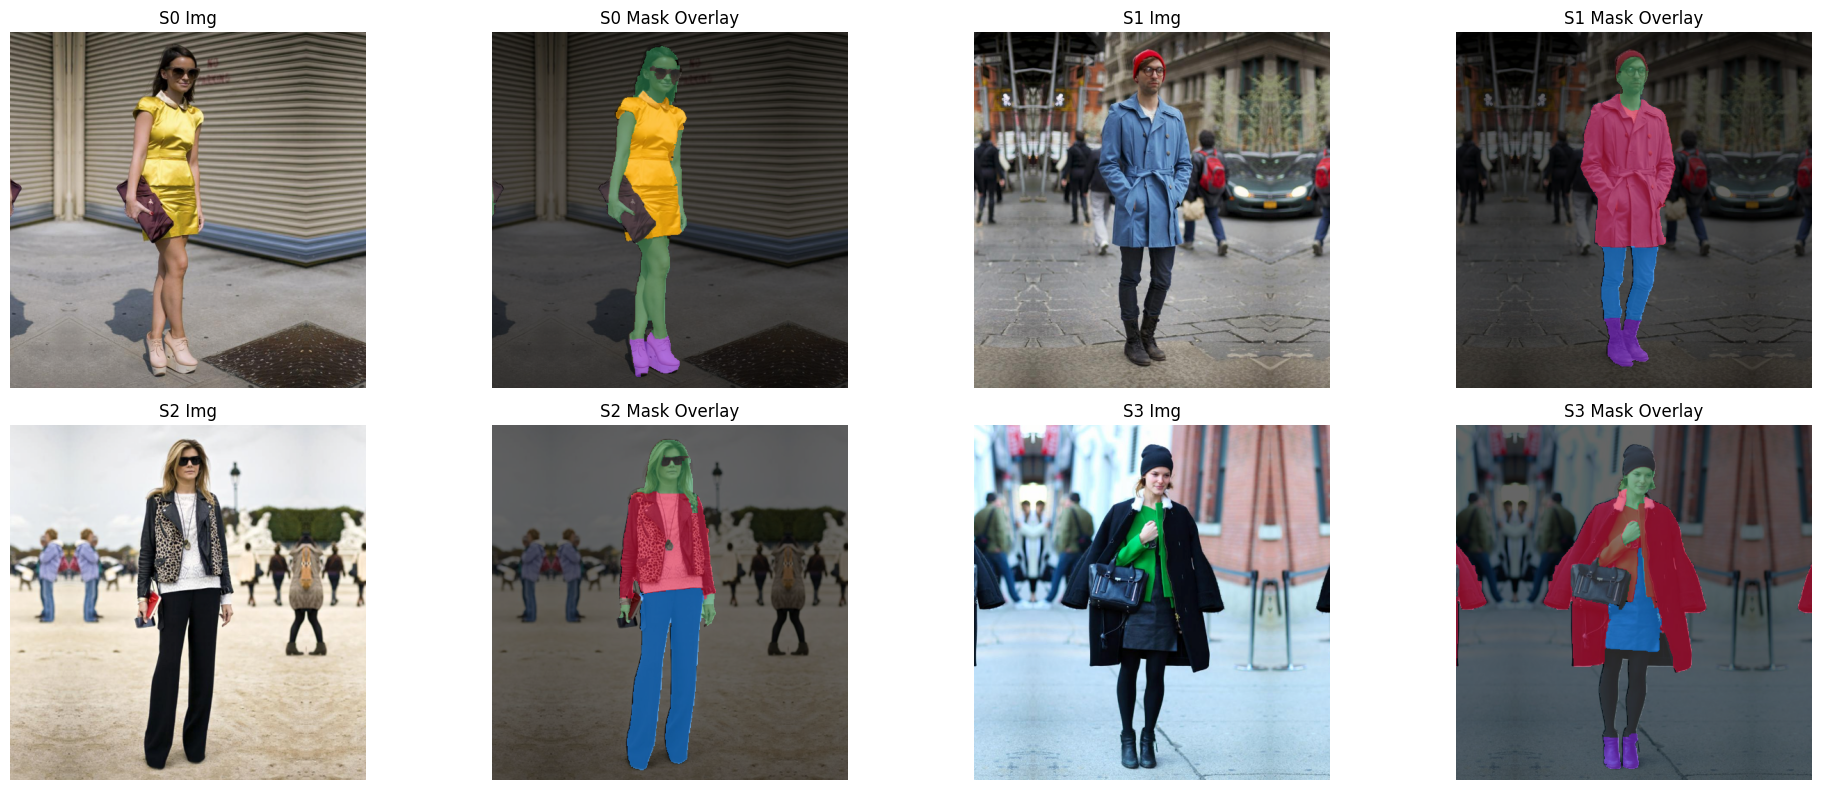


 LEYENDA DE COLORES:
  ID 0: Background   -> RGB(0,0,0)
  ID 1: Topwear      -> RGB(220,20,60)
  ID 2: Lowerwear    -> RGB(30,144,255)
  ID 3: Dress        -> RGB(255,165,0)
  ID 4: Footwear     -> RGB(138,43,226)
  ID 5: Body         -> RGB(46,139,87)
  ID 255: Ignore       -> RGB(64,64,64)


In [20]:

# =========================================================
# 1. CONFIGURACIÓN GLOBAL DE VISUALIZACIÓN
# =========================================================
# Definimos la paleta una sola vez para uso vectorizado
CLASS_COLORS_LIST = [
    [0, 0, 0],        # 0: background
    [220, 20, 60],    # 1: topwear (Crimson)
    [30, 144, 255],   # 2: lowerwear (DodgerBlue)
    [255, 165, 0],    # 3: dress (Orange)
    [138, 43, 226],   # 4: footwear (Violet)
    [46, 139, 87],    # 5: body (SeaGreen)
]

# Creamos una "Paleta Rápida" (Lookup Table) de 256 colores
# Esto permite pintar la máscara sin bucles for.
PALETTE = np.zeros((256, 3), dtype=np.uint8)
for idx, color in enumerate(CLASS_COLORS_LIST):
    PALETTE[idx] = color
PALETTE[255] = [64, 64, 64] # Gris oscuro para ignore

# =========================================================
# 2. FUNCIONES UTILITARIAS OPTIMIZADAS
# =========================================================

def denormalize_image(tensor):
    """
    Invierte la normalización de ImageNet matemáticamente (más rápido que transforms).
    Args: Tensor (C, H, W) normalizado.
    Returns: Numpy (H, W, C) uint8 listo para plotear.
    """
    # Stats de ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # 1. Mover a CPU si es necesario
    if tensor.device != 'cpu':
        tensor = tensor.cpu()

    # 2. Des-normalizar: x = z * std + mean
    tensor = tensor * std + mean

    # 3. Clip y conversión a byte
    tensor = torch.clamp(tensor * 255, 0, 255)

    # 4. (C,H,W) -> (H,W,C) y a Numpy
    return tensor.permute(1, 2, 0).byte().numpy()

def mask_to_rgb_vectorized(mask):
    """
    Convierte máscara de índices a RGB usando indexación avanzada de NumPy (Instantáneo).
    Args: mask (H, W) con índices de clases.
    """
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()

    # Asegurar que sea entero para usar como índice
    mask = mask.astype(np.uint8)

    # LA MAGIA: NumPy reemplaza cada índice por su color RGB automáticamente
    return PALETTE[mask]

def plot_sample(ax_img, ax_mask, img, mask_rgb, title_prefix=""):
    """Helper para plotear par imagen-máscara"""
    # Imagen original
    ax_img.imshow(img)
    ax_img.set_title(f"{title_prefix} Img")
    ax_img.axis("off")

    # Máscara + Overlay
    # Mostramos la máscara coloreada con un poco de transparencia sobre la imagen original
    # para verificar bordes (Overlay)
    ax_mask.imshow(img)
    ax_mask.imshow(mask_rgb, alpha=0.6) # 60% máscara, 40% imagen
    ax_mask.set_title(f"{title_prefix} Mask Overlay")
    ax_mask.axis("off")

# =========================================================
# 3. VISUALIZADOR UNIVERSAL
# =========================================================
def visualize_data(source, n_samples=4, source_type="dataset"):
    """
    Función Universal para visualizar Datasets, Subsets o DataLoaders.

    Args:
        source: El objeto (Dataset, Subset o DataLoader)
        n_samples: Cuántas imágenes mostrar
        source_type: 'dataset' (acceso aleatorio) o 'dataloader' (batch secuencial)
    """
    import math

    # Configurar grilla
    cols = 4 # 2 muestras por fila (Img + Mask cada una) -> 2 * 2 = 4 columnas
    rows = math.ceil(n_samples / 2) # Cada muestra ocupa 2 slots

    fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 4))
    axs = axs.flatten()

    print(f"\n Visualizando {source_type.upper()} ({n_samples} muestras)...")

    samples_found = 0

    # Lógica de extracción de datos
    if source_type == "dataloader":
        # Extraer del primer batch
        batch = next(iter(source))
        imgs, masks = batch[0], batch[1]
        indices = range(min(n_samples, len(imgs)))

        data_iter = zip(imgs, masks)
    else:
        # Dataset o Subset (Acceso aleatorio)
        length = len(source)
        # Evitar error si n_samples > dataset
        n_sel = min(n_samples, length)
        indices = random.sample(range(length), n_sel)
        data_iter = [source[i] for i in indices]

    # Bucle de ploteo
    plot_idx = 0
    for i, (img_tensor, mask_tensor) in enumerate(data_iter):
        if plot_idx >= len(axs): break

        # Procesar
        img_np = denormalize_image(img_tensor)
        mask_rgb = mask_to_rgb_vectorized(mask_tensor)

        # Plotear en pares (Imagen, Overlay)
        plot_sample(axs[plot_idx], axs[plot_idx+1], img_np, mask_rgb, title_prefix=f"S{i}")

        plot_idx += 2

        # Estadísticas rápidas (Opcional, útil para debug)
        unique_cls = torch.unique(mask_tensor).cpu().numpy() if torch.is_tensor(mask_tensor) else np.unique(mask_tensor)
        valid_cls = [c for c in unique_cls if c != 255]
        # print(f"  Sample {i}: Clases {valid_cls}")

    # Apagar ejes sobrantes
    for j in range(plot_idx, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# =========================================================
# 4. EJECUCIÓN (Adaptada a tu entorno)
# =========================================================

# A. Visualizar Subset de Entrenamiento (Random)
print("\n" + "="*50)
visualize_data(tr_dl.dataset, n_samples=6, source_type="dataset")

# B. Visualizar DataLoader de Validación (Batch real)
print("\n" + "="*50)
visualize_data(val_dl, n_samples=4, source_type="dataloader")

# C. Imprimir Leyenda
print("\n" + "="*50)
print(" LEYENDA DE COLORES:")
names = ["Background", "Topwear", "Lowerwear", "Dress", "Footwear", "Body"]
for idx, name in enumerate(names):
    r,g,b = PALETTE[idx]
    print(f"  ID {idx}: {name:<12} -> RGB({r},{g},{b})")
print(f"  ID 255: Ignore       -> RGB(64,64,64)")

### Setup de Entrenamiento

In [24]:
def calculate_class_weights_optimized(dataset, n_cls=6, ignore_index=255, max_samples=300):
    """
    Calcula pesos dinámicos para equilibrar el entrenamiento.
    """
    print(f" Calculando pesos de clase (Muestreo: {max_samples} imágenes)...")
    
    # Inicializamos contadores
    pixel_counts = np.zeros(n_cls, dtype=np.int64)
    total_valid_pixels = 0
    
    # Barajamos índices para tomar una muestra aleatoria real
    # Limitamos a len(dataset) por si el dataset es menor que max_samples
    n_samples = min(len(dataset), max_samples)
    indices = np.random.permutation(len(dataset))[:n_samples]

    for idx in tqdm(indices, desc="Analizando Píxeles"):
        try:
            # dataset[idx] devuelve (img, mask). Solo queremos mask [1]
            _, mask = dataset[idx]
            
            # Convertir a numpy si es tensor
            if torch.is_tensor(mask):
                mask = mask.numpy()
                
            # Aplanar y quitar ignore_index (255)
            mask_flat = mask.flatten()
            valid_mask = mask_flat != ignore_index
            valid_pixels = mask_flat[valid_mask]
            
            # Conteo rápido
            if valid_pixels.size > 0:
                unique, counts = np.unique(valid_pixels, return_counts=True)
                for u, c in zip(unique, counts):
                    if u < n_cls:
                        pixel_counts[u] += c
                        total_valid_pixels += c
                        
        except Exception as e:
            # En local a veces falla la lectura de un archivo corrupto, mejor no romper todo
            print(f" Salto imagen {idx} por error: {e}")
            continue

    # --- CÁLCULO MATEMÁTICO ---
    # 1. Frecuencia de cada clase
    pixel_counts = pixel_counts.astype(np.float32)
    # +1e-6 evita división por cero
    class_freq = pixel_counts / (total_valid_pixels + 1e-6)

    # 2. Peso Inverso (Menos frecuencia = Más peso)
    weights = 1.0 / (class_freq + 1e-6)

    # 3. Normalización: Que la suma de pesos sea igual a n_cls
    # Esto mantiene la magnitud de la Loss estable
    weights = weights / weights.sum() * n_cls

    # 4. Clipping de Seguridad (Evita explosiones)
    weights = np.clip(weights, 0.5, 10.0)

    # --- REPORTE ---
    print("\n" + "="*40)
    print(" ESTADÍSTICAS DE PESOS CALCULADOS")
    print("="*40)
    classes = dataset.get_class_names() if hasattr(dataset, 'get_class_names') else range(n_cls)
    
    for i, w in enumerate(weights):
        # Nombre de clase o ID
        c_name = classes[i] if i < len(classes) else str(i)
        freq_pct = class_freq[i] * 100
        print(f" Clase {i} | {c_name:<12} : {w:.4f} (Freq: {freq_pct:.2f}%)")
    print("="*40 + "\n")

    return torch.tensor(weights, dtype=torch.float32)

# --- EJECUCIÓN ---
# Calculamos (usando tr_dl.dataset que ya creamos antes)

class_weights_tensor = calculate_class_weights_optimized(tr_dl.dataset, n_cls=n_cls, max_samples=500)

# # Mover al dispositivo correcto (en tu caso 'cpu')
class_weights = class_weights_tensor.to(device)

 Calculando pesos de clase (Muestreo: 500 imágenes)...


Analizando Píxeles: 100%|██████████| 500/500 [01:01<00:00,  8.17it/s]


 ESTADÍSTICAS DE PESOS CALCULADOS
 Clase 0 | 0            : 0.5000 (Freq: 80.65%)
 Clase 1 | 1            : 0.5000 (Freq: 7.83%)
 Clase 2 | 2            : 0.5106 (Freq: 4.59%)
 Clase 3 | 3            : 0.7858 (Freq: 2.98%)
 Clase 4 | 4            : 3.6679 (Freq: 0.64%)
 Clase 5 | 5            : 0.7076 (Freq: 3.31%)



In [26]:

# =================================================================================
# 1. ARQUITECTURA SOTA: U-Net++ con ResNet50
# =================================================================================
class ProfessionalSegmentationModel(nn.Module):
    def __init__(self, n_cls, encoder_name="resnet50", dropout_rate=0.2):
        super().__init__()
        
        print(f" Construyendo U-Net++ con Backbone {encoder_name}...")

        # CAMBIO CLAVE: UnetPlusPlus (Mejor recuperación de bordes que DeepLab)
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=3,
            classes=n_cls,
            activation=None,  # Logits puros
            decoder_attention_type="scse", # ATENCIÓN ESPACIAL Y DE CANAL (Boost de calidad)
        )

        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# =================================================================================
# 2. INSTANCIACIÓN (ResNet50)
# =================================================================================
# Asegúrate de que device y n_cls existen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_cls = 6

# A. Recalcular pesos (Si no los tienes en memoria) o usar los anteriores
# Asumo que 'class_weights' ya existe de tu celda anterior. 
# Si no, descomenta la línea de cálculo.
# class_weights_tensor = calculate_class_weights_optimized(tr_dl.dataset, n_cls=n_cls, max_samples=300)
class_weights = class_weights_tensor.to(device, dtype=torch.float32)

# B. Crear Modelo
# OJO: ResNet50 es pesado. Si tu PC explota, cambia a 'resnet34' o 'resnet18'
model = ProfessionalSegmentationModel(n_cls=n_cls, encoder_name="resnet50")
model.to(device)

print(f" Modelo cargado en: {device}")
print(f" Parámetros: {model.count_parameters():,}")

# =================================================================================
# 3. CORRECCIÓN CRÍTICA DE LA LOSS FUNCTION
# =================================================================================
# ERROR ANTERIOR: Tenías los pesos calculados pero NO los usabas en el return.

# 1. CrossEntropy PONDERADA (Aquí es donde los pesos actúan)
ce_loss_fn = nn.CrossEntropyLoss(
    weight=class_weights,  # <--- ¡AHORA SÍ SE USAN LOS PESOS!
    ignore_index=255,
    label_smoothing=0.1
)

# 2. Dice Loss (Para la geometría)
dice_loss_fn = smp.losses.DiceLoss(
    mode='multiclass',
    classes=list(range(n_cls)),
    from_logits=True,
    ignore_index=255
)

# 3. Focal Loss (Para ejemplos difíciles)
focal_loss_fn = smp.losses.FocalLoss(
    mode='multiclass',
    ignore_index=255,
    gamma=2.0
)

def criterion(pred, gt):
    """
    ESTRATEGIA TRIFECTA:
    - 40% Dice: Para que la forma de la ropa sea correcta.
    - 40% CE Ponderada: Para obligar al modelo a detectar clases pequeñas (zapatos).
    - 20% Focal: Para refinar los casos difíciles.
    """
    loss_dice = dice_loss_fn(pred, gt)
    loss_ce   = ce_loss_fn(pred, gt)
    loss_focal = focal_loss_fn(pred, gt)
    
    return (0.4 * loss_dice) + (0.4 * loss_ce) + (0.2 * loss_focal)

print(" Función de pérdida corregida: Usa Class Weights, Dice y Focal.")

 Construyendo U-Net++ con Backbone resnet50...
 Modelo cargado en: cpu
 Parámetros: 51,126,173
 Función de pérdida corregida: Usa Class Weights, Dice y Focal.


In [27]:

# 1. Tu DiceLoss (Ligeramente optimizada)
class CustomDiceLoss(nn.Module):
    def __init__(self, n_classes, ignore_index=255, smooth=1e-6):
        super().__init__()
        self.num_classes = n_classes
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, logits, target):
        """
        logits: (B, C, H, W)
        target: (B, H, W)
        """
        # A. Máscara de Píxeles Válidos
        valid_mask = target != self.ignore_index

        # B. Softmax para obtener probabilidades
        probs = F.softmax(logits, dim=1)

        # C. One-Hot Encoding Seguro
        # Clonamos para no modificar el target original fuera de la función
        target_safe = target.clone()
        target_safe[~valid_mask] = 0  # Ponemos 0 en lo ignorado para que one_hot no falle

        target_one_hot = F.one_hot(target_safe, num_classes=self.num_classes) # (B, H, W, C)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()           # (B, C, H, W)

        # D. Aplicar máscara a ambos (importante para no contar píxeles ignorados)
        # Expandimos máscara a (B, 1, H, W) para broadcasting
        valid_mask_expanded = valid_mask.unsqueeze(1).float()

        probs = probs * valid_mask_expanded
        target_one_hot = target_one_hot * valid_mask_expanded

        # E. Calculo Dice
        dims = (0, 2, 3) # Sumar sobre Batch, Height, Width (Dejar C)
        intersection = torch.sum(probs * target_one_hot, dims)
        cardinality = torch.sum(probs + target_one_hot, dims)

        dice_score = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)

        # F. Loss = 1 - Mean Dice
        return 1.0 - dice_score.mean()

# 2. Clase Híbrida (La que usaremos en el entrenamiento)
class ClothingSegmentationLoss(nn.Module):
    def __init__(self, class_weights, n_cls, ignore_index=255):
        super().__init__()

        # A. Cross Entropy con tus pesos calculados
        # label_smoothing ayuda a que el modelo no sea tan "confiado" y generalice mejor
        self.ce = nn.CrossEntropyLoss(
            weight=class_weights,
            ignore_index=ignore_index,
            label_smoothing=0.1
        )

        # B. Tu Dice Loss
        self.dice = CustomDiceLoss(n_classes=n_cls, ignore_index=ignore_index)

    def forward(self, logits, target):
        loss_ce = self.ce(logits, target)
        loss_dice = self.dice(logits, target)

        # Combinación: 60% Dice (Forma) + 40% CE (Clasificación Ponderada)
        # Puedes jugar con esto, pero 0.5/0.5 o 0.6/0.4 suele funcionar bien.
        return 0.4 * loss_ce + 0.6 * loss_dice

# ==========================================================
# 3. INSTANCIACIÓN (Copia esto antes del bucle de train)
# ==========================================================

# Aseguramos que los pesos estén en GPU
if not torch.is_tensor(class_weights):
    class_weights = torch.tensor(class_weights).float()
class_weights = class_weights.to(device)

# Creamos la función de pérdida final
criterion = ClothingSegmentationLoss(
    class_weights=class_weights,
    n_cls=6,
    ignore_index=255
)

print(" Loss Function definida: Weighted CrossEntropy (40%) + Custom DiceLoss (60%)")

 Loss Function definida: Weighted CrossEntropy (40%) + Custom DiceLoss (60%)


In [29]:
import torch.nn.functional as F

# =================================================================================
# 1. Focal Loss Realmente Optimizada (Vectorizada)
# =================================================================================
class OptimizedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.weight = weight # Pesos de clase (Tensor)
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        """
        Calcula Focal Loss usando la implementación nativa de CrossEntropy para estabilidad numérica.
        """
        # 1. Calculamos CE sin reducción (para tener el loss por píxel)
        # OJO: Pasamos 'weight' AQUÍ directamente. PyTorch lo hace en C++ (mil veces más rápido).
        ce_loss = F.cross_entropy(
            logits, 
            target, 
            weight=self.weight, 
            ignore_index=self.ignore_index, 
            reduction='none'
        )

        # 2. Calculamos pt (probabilidad de la clase correcta)
        # pt = exp(-ce_loss) funciona matemáticamente solo si no hay weights. 
        # Si hay weights, ce_loss está escalada. Mejor recalculamos probs puras para el factor focal.
        
        with torch.no_grad(): # Ahorramos memoria, solo necesitamos probs para el factor modulador
            probs = F.softmax(logits, dim=1)
            # Gather extrae la probabilidad de la clase correcta
            # target.unsqueeze(1) -> (B, 1, H, W)
            # Manejamos ignore_index poniendo 0 temporalmente (luego se enmascara)
            target_safe = target.clone()
            target_safe[target == self.ignore_index] = 0
            pt = probs.gather(1, target_safe.unsqueeze(1)).squeeze(1)

        # 3. Factor Focal: (1 - pt)^gamma
        focal_factor = (1 - pt) ** self.gamma

        # 4. Loss Final = Factor * CE_Loss_Original (que ya tiene pesos)
        loss = focal_factor * ce_loss

        # 5. Reducción (Promedio sobre píxeles válidos)
        valid_mask = target != self.ignore_index
        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=logits.device, requires_grad=True)
            
        return loss[valid_mask].mean()

# =================================================================================
# 2. Loss Combinada (La "Trifecta")
# =================================================================================
class CombinedLoss(nn.Module):
    def __init__(self, class_weights, n_cls=6, ignore_index=255):
        super().__init__()
        
        # Aseguramos float32 y device al vuelo en el forward si es necesario, 
        # pero mejor guardarlo bien desde el init.
        if not torch.is_tensor(class_weights):
            class_weights = torch.tensor(class_weights).float()
            
        self.register_buffer('class_weights', class_weights) # Se mueve a GPU automáticamente con el modelo

        # A. Cross Entropy (Estabilidad Base)
        self.ce = nn.CrossEntropyLoss(
            weight=self.class_weights,
            ignore_index=ignore_index,
            label_smoothing=0.1
        )

        # B. Dice Loss (Forma y estructura)
        # Usamos smp.losses.DiceLoss porque es estándar y robusta
        self.dice = smp.losses.DiceLoss(
            mode='multiclass',
            classes=list(range(n_cls)),
            from_logits=True,
            ignore_index=ignore_index
        )

        # C. Focal Loss (Casos difíciles)
        self.focal = OptimizedFocalLoss(
            gamma=2.0, 
            weight=self.class_weights, 
            ignore_index=ignore_index
        )

        # Ponderación Estratégica
        # Focal y CE se pelean un poco. Dice es complementaria.
        # Sugerencia: CE para base, Dice para bordes, Focal para detalles finos.
        self.weights = {'ce': 0.3, 'dice': 0.5, 'focal': 0.2}

    def forward(self, pred, target):
        loss_ce = self.ce(pred, target)
        loss_dice = self.dice(pred, target)
        loss_focal = self.focal(pred, target)

        total = (self.weights['ce'] * loss_ce) + \
                (self.weights['dice'] * loss_dice) + \
                (self.weights['focal'] * loss_focal)
        
        return total

# =================================================================================
# 3. Instanciación
# =================================================================================
# Asegúrate de que class_weights existe de tus pasos anteriores
if 'class_weights' not in locals():
    # Fallback por seguridad si no corriste la celda anterior
    print(" Creando pesos dummy (ejecuta el cálculo real antes!)")
    class_weights = torch.ones(6).float()

class_weights = class_weights.to(device)

criterion = CombinedLoss(
    class_weights=class_weights,
    n_cls=6,
    ignore_index=255
)

print(f" Loss Function 'Trifecta' Definida.")
print(f"   Pesos: CE={criterion.weights['ce']}, Dice={criterion.weights['dice']}, Focal={criterion.weights['focal']}")

 Loss Function 'Trifecta' Definida.
   Pesos: CE=0.3, Dice=0.5, Focal=0.2


In [30]:
import torch
import torch.optim as optim

def get_optimizer_and_scheduler(model, loader, epochs, lr=3e-4, weight_decay=1e-2):
    """
    Configura AdamW y OneCycleLR sincronizados con la duración del entrenamiento.

    Args:
        weight_decay: AdamW suele funcionar mejor con decay más agresivo (ej. 1e-2)
                      que Adam estándar. 1e-4 es conservador, 1e-2 es común en papers.
    """

    # 1. Optimizador AdamW (Mejor manejo de regularización que Adam)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # 2. Scheduler OneCycleLR
    # Este scheduler ajusta el LR en cada BATCH, no en cada época.
    # Por eso necesita saber steps_per_epoch * epochs
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=epochs,             # ¡Sincronizado!
        steps_per_epoch=len(loader),
        pct_start=0.3,             # 30% Warmup es el estándar (sube), 70% Cooldown (baja)
        div_factor=25.0,           # LR inicial = max_lr / 25
        final_div_factor=1000.0,   # LR final = LR inicial / 1000
        anneal_strategy='cos'      # Coseno es más suave que lineal
    )

    print(f"  Setup: AdamW (wd={weight_decay}) + OneCycleLR")
    print(f"   Max LR: {lr}")
    print(f"   Total Steps: {epochs * len(loader)}")

    return optimizer, scheduler

# ============================================================
# EJEMPLO DE USO (Integración con tu código anterior)
# ============================================================

# 1. Definir hiperparámetros globales
EPOCHS = 30           # 30 suele ser suficiente para Fine-Tuning de segmentación
LEARNING_RATE = 3e-4  # Punto de partida seguro para EfficientNet

# 2. Instanciar usando la longitud real de tu dataloader
optimizer, scheduler = get_optimizer_and_scheduler(
    model=model,
    loader=tr_dl,       # Pasamos el dataloader para calcular len()
    epochs=EPOCHS,      # Pasamos las épocas globales
    lr=LEARNING_RATE
)

  Setup: AdamW (wd=0.01) + OneCycleLR
   Max LR: 0.0003
   Total Steps: 6000


### Entrenamiento y validacion

In [ ]:
import time
import math

class Trainer:
    """
    Trainer profesional optimizado para GPU/CPU con cálculo de métricas acumulativo.
    """
    def __init__(self, model, train_loader, val_loader,
                 criterion, optimizer, scheduler=None,
                 device="cuda", n_cls=6, ignore_index=255,
                 patience=10, delta=0.001, min_epochs=5):

        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.n_cls = n_cls
        self.ignore_index = ignore_index

        # Early Stopping
        self.patience = patience
        self.delta = delta
        self.min_epochs = min_epochs
        self.counter = 0
        self.best_score = -np.inf # Usamos mIoU, mayor es mejor
        self.early_stop = False

        # Historial
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_miou': [], 'val_miou': [],
            'train_acc': [], 'val_acc': [],
            'lr': [],
            'per_class_iou': [] # Guardaremos el dict detallado aquí
        }

    def _calculate_batch_metrics(self, logits, targets):
        """Calcula intersección y unión para un batch (rápido en GPU)"""
        preds = torch.argmax(logits, dim=1)

        valid_mask = targets != self.ignore_index
        preds = preds[valid_mask]
        targets = targets[valid_mask]

        intersection = torch.zeros(self.n_cls, device=self.device)
        union = torch.zeros(self.n_cls, device=self.device)

        for cls in range(self.n_cls):
            p_cls = (preds == cls)
            t_cls = (targets == cls)

            intersection[cls] = (p_cls & t_cls).sum().float()
            union[cls] = (p_cls | t_cls).sum().float()

        # Accuracy simple
        correct = (preds == targets).sum().float()
        total = torch.tensor(len(targets), device=self.device).float()

        return intersection, union, correct, total

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        # Acumuladores para métricas globales de la época
        epoch_intersect = torch.zeros(self.n_cls, device=self.device)
        epoch_union = torch.zeros(self.n_cls, device=self.device)
        epoch_correct = 0.0
        epoch_total = 0.0

        pbar = tqdm(self.train_loader, desc="Training", leave=False)

        for images, masks in pbar:
            images = images.to(self.device).float()
            masks = masks.to(self.device).long()

            # Forward
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)

            # Backward
            loss.backward()

            # Gradient Clipping (Opcional pero recomendado para Transformers/EfficientNet)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            # Scheduler Step (OneCycleLR requiere step por batch)
            if self.scheduler:
                self.scheduler.step()

            # Métricas
            total_loss += loss.item()

            with torch.no_grad():
                I, U, corr, tot = self._calculate_batch_metrics(outputs, masks)
                epoch_intersect += I
                epoch_union += U
                epoch_correct += corr
                epoch_total += tot

            # Log visual en barra
            current_lr = self.optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'lr': f"{current_lr:.6f}"})

        # Calcular métricas finales de la época
        avg_loss = total_loss / len(self.train_loader)

        # mIoU Global
        iou_per_class = epoch_intersect / (epoch_union + 1e-6)
        miou = iou_per_class.mean().item()

        # Accuracy Global
        acc = (epoch_correct / (epoch_total + 1e-6)).item()

        return {'loss': avg_loss, 'miou': miou, 'acc': acc}

    @torch.no_grad()
    def validate(self):
        self.model.eval()
        total_loss = 0.0

        epoch_intersect = torch.zeros(self.n_cls, device=self.device)
        epoch_union = torch.zeros(self.n_cls, device=self.device)
        epoch_correct = 0.0
        epoch_total = 0.0

        pbar = tqdm(self.val_loader, desc="Validating", leave=False)

        for images, masks in pbar:
            images = images.to(self.device).float()
            masks = masks.to(self.device).long()

            outputs = self.model(images)
            loss = self.criterion(outputs, masks)
            total_loss += loss.item()

            # Acumular I/U
            I, U, corr, tot = self._calculate_batch_metrics(outputs, masks)
            epoch_intersect += I
            epoch_union += U
            epoch_correct += corr
            epoch_total += tot

        avg_loss = total_loss / len(self.val_loader)

        # Métricas detalladas
        iou_per_class = epoch_intersect / (epoch_union + 1e-6)
        miou = iou_per_class.mean().item()
        acc = (epoch_correct / (epoch_total + 1e-6)).item()

        # Diccionario detallado por clase
        per_class_dict = {f"cls_{i}": val.item() for i, val in enumerate(iou_per_class)}

        return {'loss': avg_loss, 'miou': miou, 'acc': acc, 'per_class': per_class_dict}

    def fit(self, num_epochs, save_path="best_model_resnet50.pth"):
        print(f"  Iniciando entrenamiento en {self.device.upper()} por {num_epochs} épocas.")
        print(f"   Early Stopping: Patience={self.patience}, Min Epochs={self.min_epochs}")

        for epoch in range(num_epochs):
            start_time = time.time()

            # 1. Train
            train_metrics = self.train_epoch()

            # 2. Validate (Incluye cálculo detallado, no hace falta loop extra)
            val_metrics = self.validate()

            duration = time.time() - start_time

            # 3. Guardar Historial
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['train_miou'].append(train_metrics['miou'])
            self.history['val_miou'].append(val_metrics['miou'])
            self.history['train_acc'].append(train_metrics['acc'])
            self.history['val_acc'].append(val_metrics['acc'])
            self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
            self.history['per_class_iou'].append(val_metrics['per_class'])

            # 4. Print Stats
            print(f"\nEpoch {epoch+1}/{num_epochs} ({duration:.1f}s)")
            print(f"  Train | Loss: {train_metrics['loss']:.4f} | mIoU: {train_metrics['miou']:.4f} | Acc: {train_metrics['acc']:.4f}")
            print(f"  Val   | Loss: {val_metrics['loss']:.4f} | mIoU: {val_metrics['miou']:.4f} | Acc: {val_metrics['acc']:.4f}")

            # 5. Check Mejora y Guardado
            if val_metrics['miou'] > (self.best_score + self.delta):
                print(f"   Mejora detectada ({self.best_score:.4f} -> {val_metrics['miou']:.4f}). Guardando...")
                self.best_score = val_metrics['miou']
                self.counter = 0

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_miou': self.best_score,
                    'config': {'n_cls': self.n_cls}
                }, save_path)

                weights_only_path = save_path.replace(".pth", "_weights_only.pth")
                torch.save(self.model.state_dict(), weights_only_path)
                
            else:
                if epoch >= self.min_epochs:
                    self.counter += 1
                    print(f"   Sin mejora significativa ({self.counter}/{self.patience})")

            # 6. Early Stopping
            if self.counter >= self.patience and epoch >= self.min_epochs:
                print(f"\n  Early stopping activado en época {epoch+1}")
                break

        print("\nEntrenamiento finalizado.")
        return self.history

In [32]:
import seaborn as sns


try:
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
except ImportError:
    plt.style.use('ggplot')

class TrainingVisualizer:
    def __init__(self, history, class_names):
        """
        Clase para generar reportes visuales post-entrenamiento.
        Args:
            history (dict): El diccionario retornado por trainer.fit()
            class_names (list): Lista con nombres de clases (e.g., ['background', 'top', ...])
        """
        self.history = history
        self.class_names = class_names
        self.epochs = range(1, len(history['train_loss']) + 1)

    def plot_global_metrics(self, save_path=None):
        """
        Dashboard Global: Loss, mIoU y Learning Rate.
        Detecta Overfitting y Estabilidad.
        """
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))

        # 1. LOSS (Train vs Val)
        ax = axes[0]
        ax.plot(self.epochs, self.history['train_loss'], label='Train Loss', color='tab:blue', linewidth=2)
        ax.plot(self.epochs, self.history['val_loss'], label='Val Loss', color='tab:orange', linewidth=2, linestyle='--')

        # Marcar el mejor punto (mínimo val loss)
        best_epoch_loss = np.argmin(self.history['val_loss'])
        best_val_loss = self.history['val_loss'][best_epoch_loss]
        ax.scatter(best_epoch_loss+1, best_val_loss, c='red', s=50, zorder=5)
        ax.set_title('Cross Entropy + Dice Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

        # 2. mIoU (La métrica reina)
        ax = axes[1]
        ax.plot(self.epochs, self.history['train_miou'], label='Train mIoU', color='tab:green', linewidth=2)
        ax.plot(self.epochs, self.history['val_miou'], label='Val mIoU', color='tab:red', linewidth=2, linestyle='--')

        # Marcar el mejor mIoU
        best_epoch_iou = np.argmax(self.history['val_miou'])
        best_val_iou = self.history['val_miou'][best_epoch_iou]

        ax.axhline(best_val_iou, color='gray', linestyle=':', alpha=0.5)
        ax.text(0, best_val_iou + 0.01, f'Best Val: {best_val_iou:.4f}', fontsize=10, color='red')

        ax.set_title('Mean Intersection over Union (mIoU)')
        ax.set_xlabel('Epochs')
        ax.legend(loc='lower right')

        # 3. Learning Rate (Verificación del Scheduler)
        ax = axes[2]
        ax.plot(self.epochs, self.history['lr'], color='purple', linewidth=2)
        ax.set_title('Learning Rate Schedule')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('LR')
        ax.set_yscale('log') # Escala logarítmica para ver mejor los cambios

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f"Gráfico global guardado en {save_path}")
        plt.show()

    def plot_per_class_iou(self, save_path=None):
        """
        Visualiza la evolución del IoU para CADA clase individualmente.
        Vital para diagnosticar qué prenda está fallando.
        """
        n_cls = len(self.class_names)

        # Cálculo dinámico de filas/columnas para el grid
        cols = 3
        rows = (n_cls + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
        axes = axes.flatten()

        # Extraer datos del diccionario complejo
        # history['per_class_iou'] es una lista de dicts: [{'cls_0': 0.1, ...}, {'cls_0': 0.2, ...}]

        for i, cls_name in enumerate(self.class_names):
            ax = axes[i]

            # Extraer la serie temporal para la clase i
            # La clave en el diccionario suele ser 'cls_0', 'cls_1', etc.
            key = f"cls_{i}"

            # Robustez: intentamos obtener el valor, si falla asumimos 0
            iou_series = [epoch_data.get(key, 0) for epoch_data in self.history['per_class_iou']]

            # Plot
            ax.plot(self.epochs, iou_series, marker='o', markersize=4, linestyle='-', linewidth=2, color=plt.cm.tab10(i))

            # Estética
            ax.set_title(f"{cls_name} (ID: {i})", fontsize=12, fontweight='bold')
            ax.set_ylim(0, 1.0) # IoU siempre está entre 0 y 1
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Val IoU")

            # Línea de promedio para ver tendencia
            if len(iou_series) > 1:
                ax.axhline(max(iou_series), color='green', linestyle='--', alpha=0.3, label=f'Max: {max(iou_series):.2f}')
                ax.legend()

        # Ocultar ejes vacíos
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.suptitle(f"Validación: Evolución de IoU por Clase", fontsize=16, y=1.02)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f"Gráfico por clase guardado en {save_path}")
        plt.show()

    def print_summary(self):
        """Imprime una tabla de texto con el resumen final"""
        best_idx = np.argmax(self.history['val_miou'])
        print("="*40)
        print(f" MEJOR RESULTADO (Época {best_idx+1})")
        print("="*40)
        print(f"Train Loss: {self.history['train_loss'][best_idx]:.4f}")
        print(f"Val Loss:   {self.history['val_loss'][best_idx]:.4f}")
        print(f"Train mIoU: {self.history['train_miou'][best_idx]:.4f}")
        print(f"Val mIoU:   {self.history['val_miou'][best_idx]:.4f}")
        print("-" * 40)
        print("Desglose por clase (Val IoU):")

        last_class_metrics = self.history['per_class_iou'][best_idx]
        for i, name in enumerate(self.class_names):
            val = last_class_metrics.get(f"cls_{i}", 0)
            print(f"  {name:12s}: {val:.4f}")
        print("="*40)

In [34]:
import torch.optim as optim


def ejecutar_entrenamiento_profesional(tr_dl, val_dl, dataset_info):
    """
    Orquestador del pipeline de entrenamiento completo.
    """
    # ====================================================
    # 1. CONFIGURACIÓN (Hyperparámetros)
    # ====================================================
    CONFIG = {
        "device": "cpu",
        "n_cls": dataset_info['n_cls'],
        "ignore_index": dataset_info['ignore_index'],
        "epochs": 60,              # 30 es un buen punto para empezar
        "lr_max": 3e-4,            # Learning Rate 
        "weight_decay": 1e-4,      # Regularización para AdamW
        "patience": 8,             # Early Stopping
        "min_epochs": 10,          # Mínimo de épocas antes de parar
        "encoder": "resnet50"
    }

    print("="*60)
    print(" CONFIGURACIÓN DEL PIPELINE")
    print("="*60)
    for k, v in CONFIG.items():
        print(f"{k:15s}: {v}")


    # Aseguramos que los pesos estén en CPU y sean float32
    class_weights = class_weights_tensor.to(device, dtype=torch.float32)
    
    # ====================================================
    # 3.
    # ====================================================
    print(f"\n Construyendo modelo ({CONFIG['encoder']})...")
    model = ProfessionalSegmentationModel(
        n_cls=CONFIG['n_cls'],
        encoder_name=CONFIG['encoder'],
        dropout_rate=0.3
    ).to(CONFIG['device'])

    # ====================================================
    # 4. LOSS FUNCTION & OPTIMIZER
    # ====================================================
    # Loss Combinada (CE + Dice + Focal)
    criterion = CombinedLoss(
        class_weights=class_weights,
        n_cls=CONFIG['n_cls'],
        ignore_index=CONFIG['ignore_index']
    )

    # AdamW (Mejor que Adam estándar para visión)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['lr_max'],
        weight_decay=CONFIG['weight_decay']
    )

    # Scheduler OneCycleLR (Convergencia rápida)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=CONFIG['lr_max'],
        epochs=CONFIG['epochs'],
        steps_per_epoch=len(tr_dl),
        pct_start=0.3,
        anneal_strategy='cos'
    )

    # ====================================================
    # 5. INICIAR TRAINER
    # ====================================================
    # Usamos la clase 'Trainer' optimizada (no CPUTrainer)
    trainer = Trainer(
        model=model,
        train_loader=tr_dl,
        val_loader=val_dl,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=CONFIG['device'],
        n_cls=CONFIG['n_cls'],
        ignore_index=CONFIG['ignore_index'],
        patience=CONFIG['patience'],
        min_epochs=CONFIG['min_epochs']
    )

    # Ejecutar Fit
    history = trainer.fit(
        num_epochs=CONFIG['epochs'],
        save_path="best_model_resnet50.pth"
    )

    # ====================================================
    # 6. VISUALIZACIÓN AUTOMÁTICA
    # ====================================================
    print("\n Generando Reporte Visual...")
    try:
        viz = TrainingVisualizer(history, class_names=dataset_info['class_names'])
        viz.plot_global_metrics(save_path="global_metrics.png")
        viz.plot_per_class_iou(save_path="per_class_iou.png")
        viz.print_summary()
    except Exception as e:
        print(f"Error generando gráficos: {e}")

    return model, history

# --- EJECUCIÓN FINAL ---
# Asegúrate de pasar 'info' que obtuvimos en get_dls
# model, history = ejecutar_entrenamiento_profesional(tr_dl, val_dl, info)

In [36]:
def verificacion_previa_profesional(tr_dl, val_dl, dataset_info):
    """
    Verificación profunda de tipos, rangos y consistencia de clases.
    """
    print("=" * 70)
    print(" VERIFICACIÓN DE INTEGRIDAD DE DATOS (PRE-ENTRENAMIENTO)")
    print("=" * 70)

    # 1. Recuperar nombres de clases dinámicamente
    # Si usaste get_dls, dataset_info tiene el mapeo
    idx_to_label = dataset_info.get('idx_to_label', {})

    # Fallback si está vacío
    if not idx_to_label:
        idx_to_label = {0: "background", 1: "top", 2: "bottom", 3: "dress", 4: "shoes", 5: "body", 255: "ignore"}

    print(f"Clases registradas: {len(idx_to_label)} (sin contar ignore)")

    # 2. Análisis del Batch de Entrenamiento
    try:
        # Extraer un batch
        images, masks = next(iter(tr_dl))

        print("\n BATCH DE ENTRENAMIENTO:")
        print(f"  ➜ Tensor Shape Images: {images.shape} (B, C, H, W)")
        print(f"  ➜ Tensor Shape Masks:  {masks.shape}  (B, H, W)")
        print(f"  ➜ Dtype Images:        {images.dtype}")
        print(f"  ➜ Dtype Masks:         {masks.dtype} (¡CRÍTICO: Debe ser int64/long!)")

        # Verificación de Normalización
        img_min, img_max = images.min().item(), images.max().item()
        print(f"  ➜ Rango de Valores:    [{img_min:.3f}, {img_max:.3f}]")

        if img_min < -1.0 or img_max > 2.0:
            print("     ℹ INFO: Los valores sugieren normalización estándar (ImageNet). Correcto.")
        elif img_min >= 0 and img_max <= 1:
            print("      ALERTA: Los valores están entre [0, 1]. ¿Se aplicó la normalización de ImageNet?")
        elif img_max > 1.5 and img_max <= 255:
            print("      ERROR CRÍTICO: La imagen parece estar en rango [0, 255]. El modelo no aprenderá. Revisa 'ToTensorV2' o normalización.")

        # Verificación de Clases en el Batch
        unique_classes = torch.unique(masks).tolist()
        print(f"\n  ➜ Clases detectadas en este batch: {unique_classes}")

        print("     Desglose:")
        for cls_id in unique_classes:
            count = (masks == cls_id).sum().item()
            name = idx_to_label.get(cls_id, "IGNORE" if cls_id==255 else "UNKNOWN")
            print(f"       - ID {cls_id:<3} ({name:^10}): {count:7d} píxeles")

        # 3. Validación Cruzada (Mask vs Image)
        if images.shape[0] != masks.shape[0]:
            print(" ERROR: El batch size de imágenes y máscaras no coincide.")
            return False

        if images.shape[2:] != masks.shape[-2:]:
            print(f" ERROR: Dimensiones espaciales no coinciden: Img {images.shape[2:]} vs Mask {masks.shape[-2:]}")
            return False

    except Exception as e:
        print(f"\n ERROR FATAL al cargar el batch: {e}")
        return False

    # 4. Verificación Rápida de Validación
    print("\n BATCH DE VALIDACIÓN (Check rápido):")
    try:
        val_imgs, val_masks = next(iter(val_dl))
        print(f"  ➜ Val Images Shape: {val_imgs.shape}")
        print(f"  ➜ Val Masks Shape:  {val_masks.shape}")
        if val_masks.dtype != torch.int64:
             print(f"   ERROR: Las máscaras de validación son {val_masks.dtype}, deben ser int64.")
    except Exception as e:
         print(f" Error cargando validación: {e}")
         return False

    print("\n" + "="*70)
    print("RESULTADO: " + (" DATOS LISTOS" if masks.dtype == torch.int64 else " REVISAR DTYPES"))
    print("="*70)
    return True

# --- EJECUTAR VERIFICACIÓN ---
datos_correctos = verificacion_previa_profesional(tr_dl, val_dl, info)

if datos_correctos:
    print("\n Todo en orden. Procediendo al entrenamiento...")
    # AQUÍ EJECUTAS TU LÍNEA DE ENTRENAMIENTO
    model, history = ejecutar_entrenamiento_profesional(tr_dl, val_dl, info)
else:
    print("\n DETENIDO: Corrige los errores de datos antes de entrenar.")

 VERIFICACIÓN DE INTEGRIDAD DE DATOS (PRE-ENTRENAMIENTO)
Clases registradas: 7 (sin contar ignore)

 BATCH DE ENTRENAMIENTO:
  ➜ Tensor Shape Images: torch.Size([4, 3, 512, 512]) (B, C, H, W)
  ➜ Tensor Shape Masks:  torch.Size([4, 512, 512])  (B, H, W)
  ➜ Dtype Images:        torch.float32
  ➜ Dtype Masks:         torch.int64 (¡CRÍTICO: Debe ser int64/long!)
  ➜ Rango de Valores:    [-2.118, 2.640]
     ℹ INFO: Los valores sugieren normalización estándar (ImageNet). Correcto.

  ➜ Clases detectadas en este batch: [0, 1, 2, 3, 4, 5, 255]
     Desglose:
       - ID 0   (background):  809270 píxeles
       - ID 1   (   top    ):   81431 píxeles
       - ID 2   (  bottom  ):   18147 píxeles
       - ID 3   (  dress   ):   74061 píxeles
       - ID 4   (  shoes   ):    2516 píxeles
       - ID 5   (   body   ):   37037 píxeles
       - ID 255 (  ignore  ):   26114 píxeles

 BATCH DE VALIDACIÓN (Check rápido):
  ➜ Val Images Shape: torch.Size([4, 3, 512, 512])
  ➜ Val Masks Shape:  torch.S

KeyboardInterrupt: 

In [22]:

def evaluar_test_profesional(model, test_loader, device, n_cls, ignore_index=255):
    """
    Evalúa el modelo en el set de TEST calculando mIoU y Accuracy.
    Optimizado para GPU.
    """
    print("="*60)
    print(" INICIANDO EVALUACIÓN EN TEST SET...")
    print("="*60)

    model.eval()

    # Acumuladores globales
    intersect_total = torch.zeros(n_cls, device=device)
    union_total = torch.zeros(n_cls, device=device)
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device).float()
            masks = masks.to(device).long()

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Filtramos píxeles válidos (no ignore)
            valid_mask = masks != ignore_index
            preds_valid = preds[valid_mask]
            masks_valid = masks[valid_mask]

            # 1. Pixel Accuracy Global
            correct_pixels += (preds_valid == masks_valid).sum().item()
            total_pixels += len(masks_valid)

            # 2. IoU por clase (Vectorizado)
            for cls in range(n_cls):
                p_cls = (preds_valid == cls)
                t_cls = (masks_valid == cls)

                intersect_total[cls] += (p_cls & t_cls).sum().float()
                union_total[cls] += (p_cls | t_cls).sum().float()

    # --- CÁLCULO FINAL ---
    # Global Pixel Accuracy
    test_acc = correct_pixels / (total_pixels + 1e-6)

    # Mean IoU
    iou_per_class = intersect_total / (union_total + 1e-6)
    test_miou = iou_per_class.mean().item()

    # Reporte
    print(f"\n RESULTADOS FINALES EN TEST:")
    print(f"  ➜ Global Pixel Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  ➜ Mean IoU (mIoU):       {test_miou:.4f} ({test_miou*100:.2f}%)")
    print("-" * 40)
    print("  ➜ Desglose por clase (IoU):")

    # Intentamos obtener nombres si existen en info
    try:
        names = info['class_names']
    except:
        names = [f"Class {i}" for i in range(n_cls)]

    for i, iou in enumerate(iou_per_class):
        name = names[i] if i < len(names) else str(i)
        print(f"     • {name:12s}: {iou:.4f}")

    print("="*60)

    return test_acc, test_miou

# EJECUCIÓN (Usando el mejor modelo cargado en memoria o re-cargado)
# Asegúrate de que 'model' tiene los pesos del mejor epoch, no del último.
# Si history ya terminó, el trainer ya cargó el mejor modelo si usaste mi código anterior.

test_acc, test_miou = evaluar_test_profesional(
    model,
    test_dl,
    device="cpu",  # ¡Usa GPU!
    n_cls=info['n_cls'],
    ignore_index=255
)

 INICIANDO EVALUACIÓN EN TEST SET...

 RESULTADOS FINALES EN TEST:
  ➜ Global Pixel Accuracy: 0.9610 (96.10%)
  ➜ Mean IoU (mIoU):       0.6558 (65.58%)
----------------------------------------
  ➜ Desglose por clase (IoU):
     • background  : 0.9839
     • topwear     : 0.7300
     • lowerwear   : 0.6040
     • dress       : 0.3128
     • footwear    : 0.5412
     • body        : 0.7627


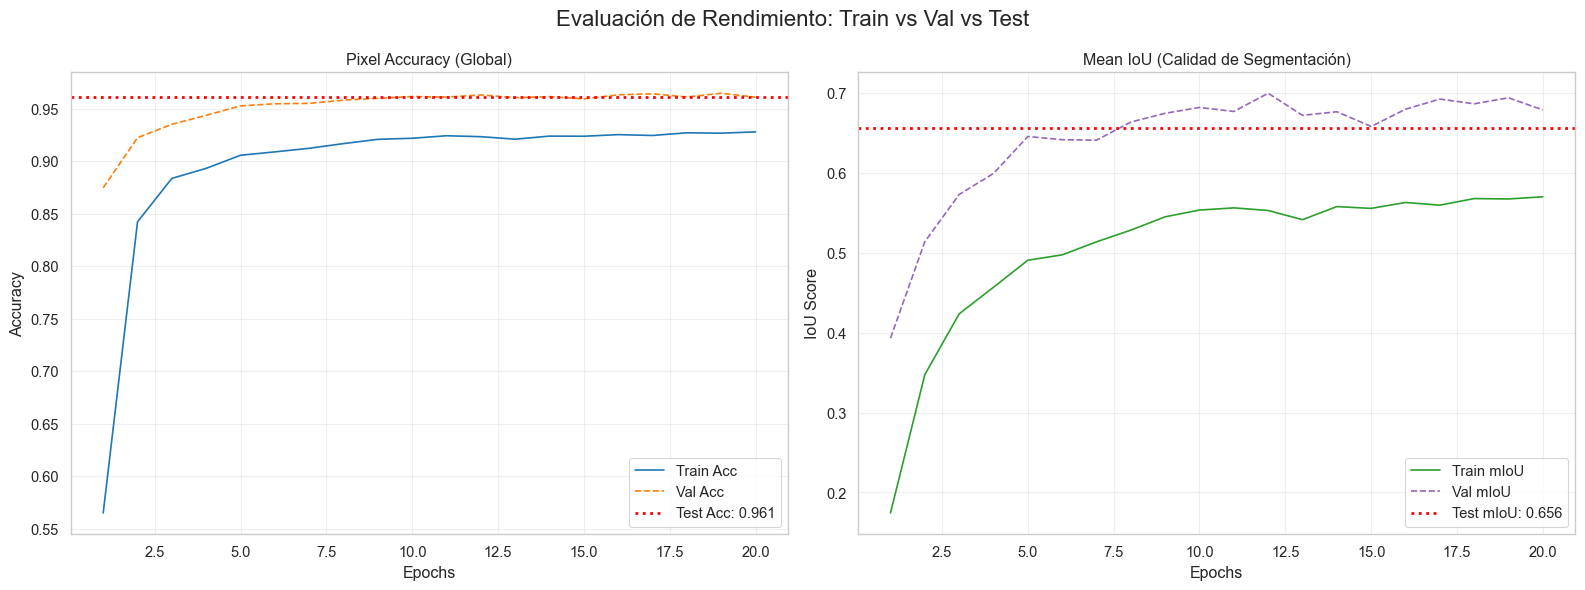

In [23]:
def plot_comparative_metrics(history, test_acc, test_miou):
    """
    Gráfica profesional que compara Accuracy y mIoU, mostrando la línea de base del Test.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Ajuste de claves (compatibilidad con tu Trainer)
    # Si usaste mi Trainer, las claves son 'train_acc', 'val_acc', 'train_miou'
    t_acc = history['train_acc']
    v_acc = history['val_acc']
    t_iou = history['train_miou']
    v_iou = history['val_miou']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- GRÁFICO 1: PIXEL ACCURACY ---
    ax = axes[0]
    ax.plot(epochs, t_acc, label='Train Acc', color='tab:blue')
    ax.plot(epochs, v_acc, label='Val Acc', color='tab:orange', linestyle='--')
    ax.axhline(test_acc, color='red', linestyle=':', label=f'Test Acc: {test_acc:.3f}', linewidth=2)

    ax.set_title("Pixel Accuracy (Global)")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # --- GRÁFICO 2: MEAN IOU (La métrica importante) ---
    ax = axes[1]
    ax.plot(epochs, t_iou, label='Train mIoU', color='tab:green')
    ax.plot(epochs, v_iou, label='Val mIoU', color='tab:purple', linestyle='--')
    ax.axhline(test_miou, color='red', linestyle=':', label=f'Test mIoU: {test_miou:.3f}', linewidth=2)

    ax.set_title("Mean IoU (Calidad de Segmentación)")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("IoU Score")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle("Evaluación de Rendimiento: Train vs Val vs Test", fontsize=16)
    plt.tight_layout()
    plt.show()

# EJECUTAR VISUALIZACIÓN
plot_comparative_metrics(history, test_acc, test_miou)

 Calculando Matriz de Confusión (CPU)...


Evaluando:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluando: 100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


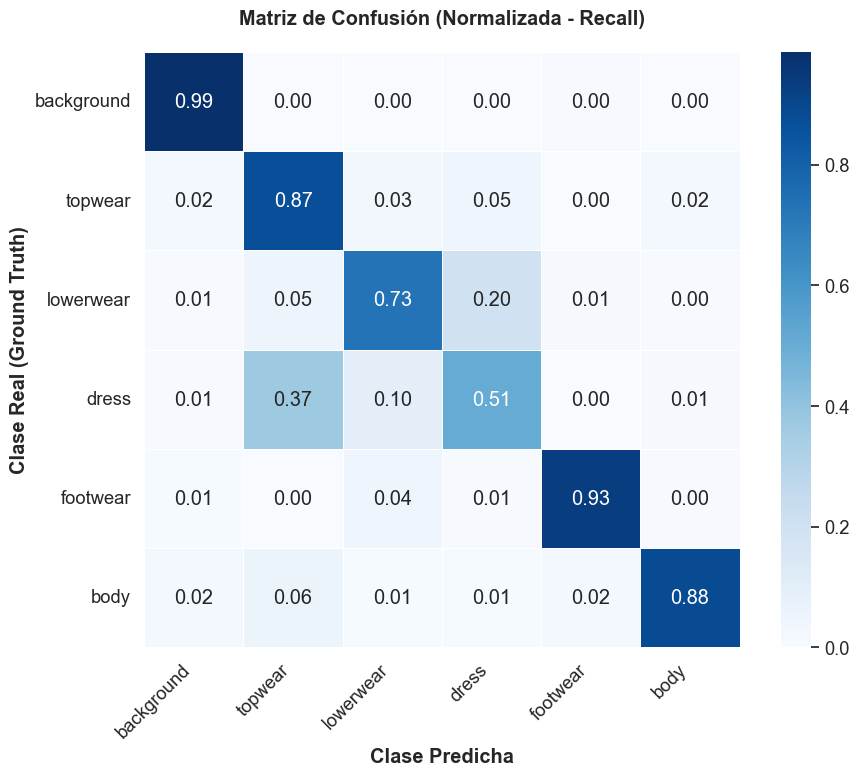

In [25]:


@torch.no_grad()
def compute_confusion_matrix_optimized(model, dataloader, n_cls, device="cuda", ignore_index=255):
    """
    Calcula la matriz de confusión de forma incremental en GPU.
    Evita guardar millones de píxeles en RAM.
    """
    print(f" Calculando Matriz de Confusión ({device.upper()})...")
    model.eval()

    # Inicializamos la matriz vacía en el dispositivo (6x6)
    confusion_matrix = torch.zeros((n_cls, n_cls), dtype=torch.long, device=device)

    for images, masks in tqdm(dataloader, desc="Evaluando"):
        images = images.to(device).float()
        masks = masks.to(device).long()

        # 1. Inferencia
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)

        # 2. Aplanar dimensiones
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)

        # 3. Filtrar ignore_index
        valid_mask = masks_flat != ignore_index
        p_valid = preds_flat[valid_mask]
        t_valid = masks_flat[valid_mask]

        # 4. Truco Vectorial para Matriz de Confusión:
        # Codificamos (Target, Pred) en un solo número: index = Target * n_cls + Pred
        # Esto aplana la matriz 2D a 1D.
        unique_mapping = t_valid * n_cls + p_valid

        # Contamos ocurrencias (bincount es extremadamente rápido en GPU)
        counts = torch.bincount(unique_mapping, minlength=n_cls**2)

        # Reformateamos a (n_cls, n_cls) y sumamos al acumulador
        confusion_matrix += counts.view(n_cls, n_cls)

    return confusion_matrix.cpu().numpy()

def plot_confusion_matrix_professional(cm, class_names=None, normalize=True, title='Matriz de Confusión'):
    """
    Visualización profesional con opción de normalización.
    """
    if class_names is None:
        class_names = [str(i) for i in range(len(cm))]

    # Normalización (Recall por clase: qué porcentaje de la clase real X fue predicha como X)
    if normalize:
        # Sumamos por filas (Ground Truth) + epsilon para evitar división por cero
        cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
        fmt = ".2f"
        val_to_plot = cm_norm
        title = f"{title} (Normalizada - Recall)"
    else:
        fmt = "d"
        val_to_plot = cm
        title = f"{title} (Conteo de Píxeles)"

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)

    heatmap = sns.heatmap(
        val_to_plot,
        annot=True,
        fmt=fmt,
        cmap='Blues',
        cbar=True,
        xticklabels=class_names,
        yticklabels=class_names,
        square=True,
        linewidths=.5
    )

    plt.ylabel('Clase Real (Ground Truth)', fontweight='bold')
    plt.xlabel('Clase Predicha', fontweight='bold')
    plt.title(title, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ============================================
# EJECUCIÓN
# ============================================

# 1. Calcular (Usamos test_dl para la evaluación final)
# Asegúrate de usar 'test_dl' y no 'val_dl' para el reporte final
cm = compute_confusion_matrix_optimized(
    model,
    test_dl,
    n_cls=info['n_cls'],
    device="cpu",  # Usar GPU es vital aquí
    ignore_index=255
)

# 2. Visualizar Normalizada (Muestra porcentajes, mejor para entender calidad)
plot_confusion_matrix_professional(
    cm,
    class_names=info['class_names'],
    normalize=True
)

# 3. (Opcional) Visualizar Conteos Brutos (Para ver desbalance de clases)
# plot_confusion_matrix_professional(cm, class_names=info['class_names'], normalize=False)

In [26]:
def compute_iou_metrics_from_cm(cm, class_names):
    """
    Calcula IoU por clase y mIoU directamente desde la matriz de confusión.
    No requiere volver a procesar el dataset.
    """
    # 1. Extraer Verdaderos Positivos (Diagonal)
    TP = np.diag(cm)

    # 2. Calcular Falsos Positivos y Falsos Negativos
    # Suma por columnas (Predicciones) - TP = FP
    FP = cm.sum(axis=0) - TP

    # Suma por filas (Ground Truth) - TP = FN
    FN = cm.sum(axis=1) - TP

    # 3. Calcular Unión (TP + FP + FN)
    union = TP + FP + FN

    # 4. IoU (Intersection over Union)
    # Agregamos epsilon para evitar división por cero en clases vacías
    iou = TP / (union + 1e-6)

    # 5. Mean IoU
    miou = np.nanmean(iou) # Usamos nanmean por si alguna clase no existía

    # Empaquetar en diccionario
    iou_dict = {name: score for name, score in zip(class_names, iou)}

    print(f"\n RESULTADOS CALCULADOS DESDE MATRIZ:")
    print(f"  ➜ Global mIoU: {miou:.4f} ({miou*100:.2f}%)")

    return iou_dict, miou

In [27]:

def plot_iou_per_class_enhanced(iou_dict, miou, title="IoU por Clase (Test Set)"):
    """
    Visualización mejorada del IoU con métricas explícitas y thresholding visual.
    """
    # Ordenar datos para mejor visualización (opcional, aquí mantenemos orden de clases)
    classes = list(iou_dict.keys())
    scores = list(iou_dict.values())

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Paleta de colores dinámica: Rojo si < 0.5, Amarillo < 0.7, Verde >= 0.7
    colors = ['#ff4d4d' if x < 0.5 else '#ffcc00' if x < 0.7 else '#2ecc71' for x in scores]

    # Barplot
    bars = plt.bar(classes, scores, color=colors, alpha=0.8, edgecolor='black')

    # Línea de mIoU
    plt.axhline(miou, color='navy', linestyle='--', linewidth=2, label=f'Mean IoU: {miou:.3f}')

    # Etiquetas sobre las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.01,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold'
        )

    plt.ylim(0, 1.1) # Dejar espacio arriba para las etiquetas
    plt.ylabel("IoU Score", fontsize=12, fontweight='bold')
    plt.xlabel("Clases", fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45, ha='right')

    # Tabla de resumen pequeña en la esquina (opcional)
    # plt.table(...)

    plt.tight_layout()
    plt.show()


 RESULTADOS CALCULADOS DESDE MATRIZ:
  ➜ Global mIoU: 0.6558 (65.58%)


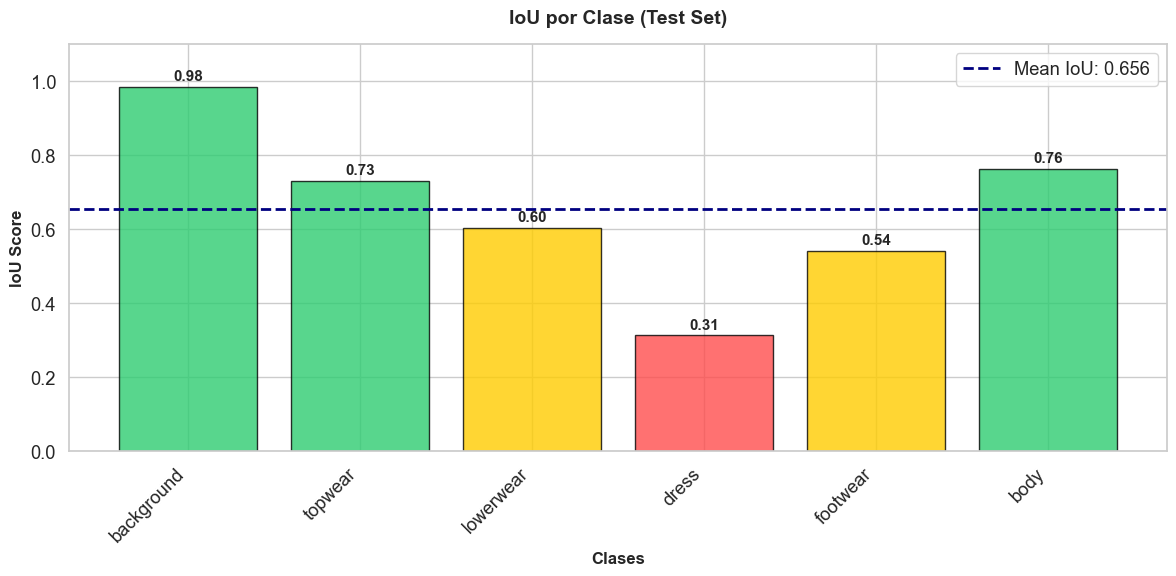


 DIAGNÓSTICO DE RENDIMIENTO:
   Mejor Clase: background (0.9839)
   Peor Clase:  dress (0.3128)
    Consejo: La clase 'dress' tiene bajo rendimiento.
     - Revisa si hay pocas muestras en el dataset.
     - Verifica si el peso en la Loss Function (CrossEntropy) es suficiente.


In [28]:
# ==============================================================================
# ANÁLISIS DE IOU (DERIVADO DE LA MATRIZ DE CONFUSIÓN)
# ==============================================================================

# Asumimos que 'cm' y 'info' existen de tu celda anterior

if 'cm' in locals() and 'info' in locals():
    # 1. Calcular IoU matemáticamente desde la CM (Instantáneo)
    iou_dict, miou_final = compute_iou_metrics_from_cm(cm, info['class_names'])

    # 2. Visualizar
    plot_iou_per_class_enhanced(iou_dict, miou_final)

    # 3. Diagnóstico Automático (Feedback de Especialista)
    print("\n DIAGNÓSTICO DE RENDIMIENTO:")
    sorted_iou = sorted(iou_dict.items(), key=lambda x: x[1])
    worst_class = sorted_iou[0]
    best_class = sorted_iou[-1]

    print(f"   Mejor Clase: {best_class[0]} ({best_class[1]:.4f})")
    print(f"   Peor Clase:  {worst_class[0]} ({worst_class[1]:.4f})")

    if worst_class[1] < 0.4:
        print(f"    Consejo: La clase '{worst_class[0]}' tiene bajo rendimiento.")
        print("     - Revisa si hay pocas muestras en el dataset.")
        print("     - Verifica si el peso en la Loss Function (CrossEntropy) es suficiente.")
else:
    print(" Error: La variable 'cm' (matriz de confusión) no está definida. Ejecuta la celda anterior.")

 REPORTE DETALLADO DE CLASIFICACIÓN (DERIVADO DE CM)
CLASE           | PRECISION  | RECALL     | F1-SCORE  
-------------------------------------------------------
background      | 0.9972     | 0.9866     | 0.9919
topwear         | 0.8181     | 0.8715     | 0.8439
lowerwear       | 0.7792     | 0.7287     | 0.7531
dress           | 0.4509     | 0.5051     | 0.4765
footwear        | 0.5629     | 0.9334     | 0.7023
body            | 0.8484     | 0.8830     | 0.8654
-------------------------------------------------------
MACRO AVG       | 0.7428     | 0.8180     | 0.7722


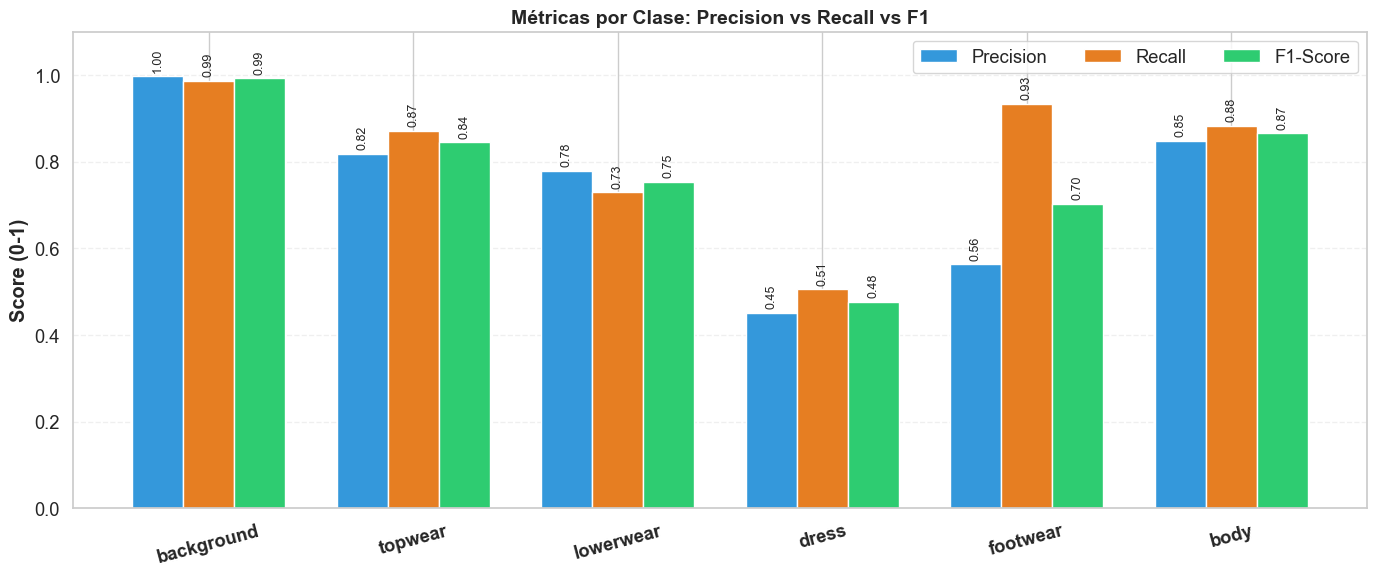

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def compute_comprehensive_metrics_from_cm(cm, class_names):
    """
    Calcula Precision, Recall y F1 para cada clase directamente desde la Matriz de Confusión.
    Coste computacional: Cero (instantáneo).
    """
    # 1. Extraer componentes básicos
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP  # Falsos Positivos (Columna - Diagonal)
    FN = cm.sum(axis=1) - TP  # Falsos Negativos (Fila - Diagonal)

    # 2. Cálculos (con epsilon para evitar división por cero)
    epsilon = 1e-7

    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    # Limpiar NaNs en caso de clases vacías
    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    f1 = np.nan_to_num(f1)

    # 3. Empaquetar
    metrics = {
        "precision": {name: val for name, val in zip(class_names, precision)},
        "recall":    {name: val for name, val in zip(class_names, recall)},
        "f1":        {name: val for name, val in zip(class_names, f1)}
    }

    # 4. Imprimir Reporte de Texto
    print("="*60)
    print(" REPORTE DETALLADO DE CLASIFICACIÓN (DERIVADO DE CM)")
    print("="*60)
    print(f"{'CLASE':<15} | {'PRECISION':<10} | {'RECALL':<10} | {'F1-SCORE':<10}")
    print("-" * 55)

    for i, name in enumerate(class_names):
        print(f"{name:<15} | {precision[i]:.4f}     | {recall[i]:.4f}     | {f1[i]:.4f}")

    print("-" * 55)
    print(f"{'MACRO AVG':<15} | {np.mean(precision):.4f}     | {np.mean(recall):.4f}     | {np.mean(f1):.4f}")
    print("="*60)

    return metrics

def plot_metrics_grouped(metrics_dict):
    """
    Gráfico de barras agrupadas profesional.
    """
    classes = list(metrics_dict["precision"].keys())

    p = list(metrics_dict["precision"].values())
    r = list(metrics_dict["recall"].values())
    f = list(metrics_dict["f1"].values())

    x = np.arange(len(classes))
    width = 0.25  # Ancho de las barras

    fig, ax = plt.subplots(figsize=(14, 6))

    # Barras
    rects1 = ax.bar(x - width, p, width, label='Precision', color='#3498db') # Azul
    rects2 = ax.bar(x, r, width, label='Recall', color='#e67e22')        # Naranja
    rects3 = ax.bar(x + width, f, width, label='F1-Score', color='#2ecc71')   # Verde

    # Textos y Títulos
    ax.set_ylabel('Score (0-1)', fontweight='bold')
    ax.set_title('Métricas por Clase: Precision vs Recall vs F1', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=15, fontweight='bold')
    ax.set_ylim(0, 1.1) # Espacio para leyenda
    ax.legend(loc='upper right', ncol=3)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Función para poner etiquetas encima de las barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, rotation=90)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

# =========================================================
# EJECUCIÓN (Usando la 'cm' que calculaste en el paso anterior)
# =========================================================

if 'cm' in locals():
    # 1. Calcular métricas sin saturar la RAM
    metrics_dict = compute_comprehensive_metrics_from_cm(cm, info['class_names'])

    # 2. Graficar
    plot_metrics_grouped(metrics_dict)

else:
    print(" Error: No se encontró la variable 'cm'. Por favor ejecuta el cálculo de la matriz de confusión primero.")

 VISUALIZADOR DE RESULTADOS 
Visualizando 4 ejemplos aleatorios...


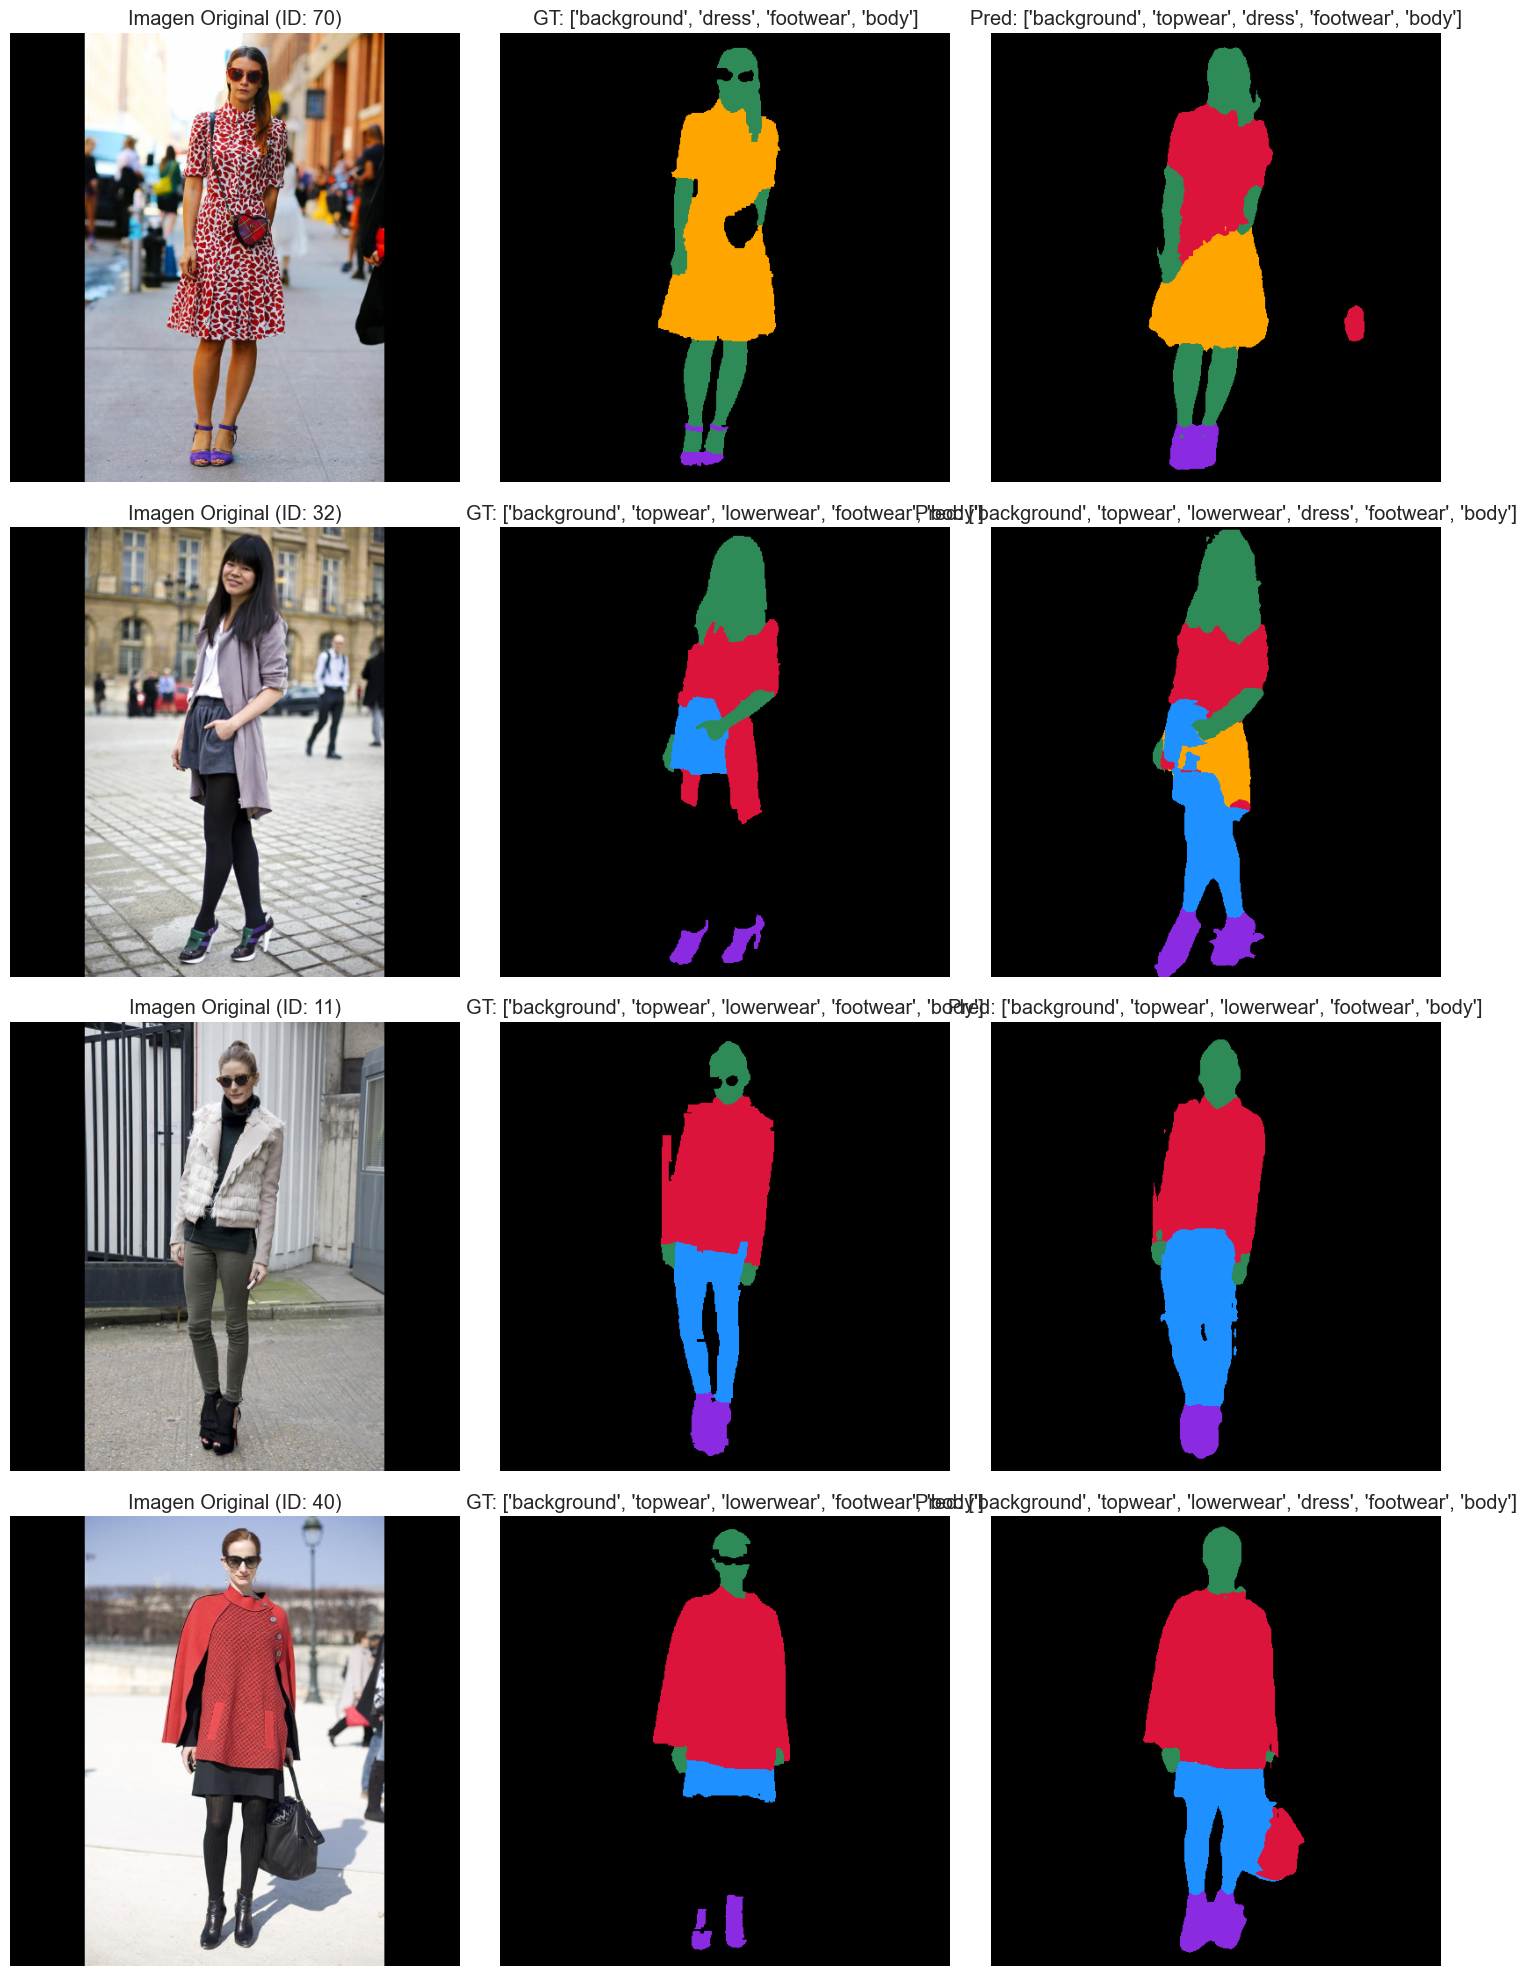

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# ==========================================
# 1. FUNCIONES AUXILIARES (NECESARIAS)
# ==========================================

# Paleta de colores fija para tus 6 clases (Fondo=Negro, Ropa=Colores vivos)
CLASS_COLORS_LIST = [
    [0, 0, 0],        # 0: background
    [220, 20, 60],    # 1: topwear (Crimson)
    [30, 144, 255],   # 2: lowerwear (DodgerBlue)
    [255, 165, 0],    # 3: dress (Orange)
    [138, 43, 226],   # 4: footwear (Violet)
    [46, 139, 87],    # 5: body (SeaGreen)
]

# Creamos una "Paleta Rápida" (Lookup Table) de 256 colores
# Esto permite pintar la máscara sin bucles for.
PALETTE = np.zeros((256, 3), dtype=np.uint8)
for idx, color in enumerate(CLASS_COLORS_LIST):
    PALETTE[idx] = color
PALETTE[255] = [64, 64, 64] # Gris oscuro para ignore

def to_numpy_image(tensor):
    """
    Convierte tensor normalizado (ImageNet) a imagen numpy visible [0,1]
    """
    # Media y Std de ImageNet (usadas en tu transformación)
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    img = tensor.cpu().numpy().transpose(1, 2, 0) # (C,H,W) -> (H,W,C)
    img = img * STD + MEAN # Des-normalizar
    img = np.clip(img, 0, 1) # Asegurar rango válido
    return img

def mask_to_rgb(mask, palette=PALETTE):
    """
    Convierte una máscara de índices (H,W) a imagen RGB (H,W,3) usando la paleta.
    """
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()
    
    # Manejo de ignore_index (pintar de negro o blanco)
    mask[mask == 255] = 0 
    
    # Asegurar que no nos salimos de la paleta
    mask[mask >= len(palette)] = 0
    
    return palette[mask.astype(int)]

@torch.no_grad()
def predict_mask(model, image, device):
    """
    Realiza la predicción sobre una sola imagen
    """
    model.eval()
    # Añadir batch dim: (3,H,W) -> (1,3,H,W)
    image_batch = image.unsqueeze(0).to(device)
    
    outputs = model(image_batch)
    
    # Si la salida es un diccionario (DeepLab a veces devuelve 'out'), extraemos
    if isinstance(outputs, dict):
        outputs = outputs['out']
        
    pred = torch.argmax(outputs, dim=1) # (1,H,W)
    return pred.squeeze(0).cpu() # (H,W)

def get_present_classes(mask, class_names, ignore_index=255):
    """
    Devuelve lista de nombres de clases presentes en la máscara
    """
    if torch.is_tensor(mask):
        vals = torch.unique(mask).cpu().numpy()
    else:
        vals = np.unique(mask)
    
    names = []
    for v in vals:
        if v != ignore_index and v < len(class_names):
            names.append(class_names[int(v)])
    return names

# ==========================================
# 2. FUNCIÓN DE VISUALIZACIÓN PRINCIPAL
# ==========================================

def visualize_prediction_sample(model, dataset, class_names, n_samples=3, device="cpu"):
    """
    Visualiza: Imagen | Ground Truth | Predicción del Modelo
    """
    print(f"Visualizando {n_samples} ejemplos aleatorios...")
    
    # Selección aleatoria segura
    n_samples = min(n_samples, len(dataset))
    indices = random.sample(range(len(dataset)), n_samples)
    
    fig, axs = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))
    if n_samples == 1: axs = axs[np.newaxis, :] # Parche para 1 sola muestra
    
    for i, idx in enumerate(indices):
        image_tensor, mask_gt = dataset[idx]
        
        # 1. Preparar Imagen
        img_vis = to_numpy_image(image_tensor)
        
        # 2. Preparar GT
        gt_vis = mask_to_rgb(mask_gt)
        gt_cls = get_present_classes(mask_gt, class_names)
        
        # 3. Predecir
        mask_pred = predict_mask(model, image_tensor, device)
        pred_vis = mask_to_rgb(mask_pred)
        pred_cls = get_present_classes(mask_pred, class_names)
        
        # --- PLOT ---
        # Columna 1: Imagen Original
        axs[i, 0].imshow(img_vis)
        axs[i, 0].set_title(f"Imagen Original (ID: {idx})")
        axs[i, 0].axis('off')
        
        # Columna 2: Ground Truth
        axs[i, 1].imshow(gt_vis)
        axs[i, 1].set_title(f"GT: {gt_cls}")
        axs[i, 1].axis('off')
        
        # Columna 3: Predicción
        axs[i, 2].imshow(pred_vis)
        axs[i, 2].set_title(f"Pred: {pred_cls}")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# ==========================================
# 3. EJECUCIÓN
# ==========================================

print("=" * 60)
print(" VISUALIZADOR DE RESULTADOS ")
print("=" * 60)

# Usamos la lista de nombres que ya tienes en 'info'
# Si no la tienes definida, descomenta la siguiente línea:
# info = {'class_names': ["Fondo", "Top", "Lower", "Dress", "Foot", "Body"]}

if 'model' in locals() and 'val_dl' in locals():
    visualize_prediction_sample(
        model=model,
        dataset=val_dl.dataset,      # Usamos el dataset de validación
        class_names=info['class_names'], 
        n_samples=4,                 # Cantidad de fotos a probar
        device="cpu"                 # Tu dispositivo actual
    )
else:
    print(" Error: Asegúrate de que 'model' y 'val_dl' estén definidos.")

 ANALIZANDO 3 MUESTRAS DEL SET DE VALIDACIÓN/TEST...


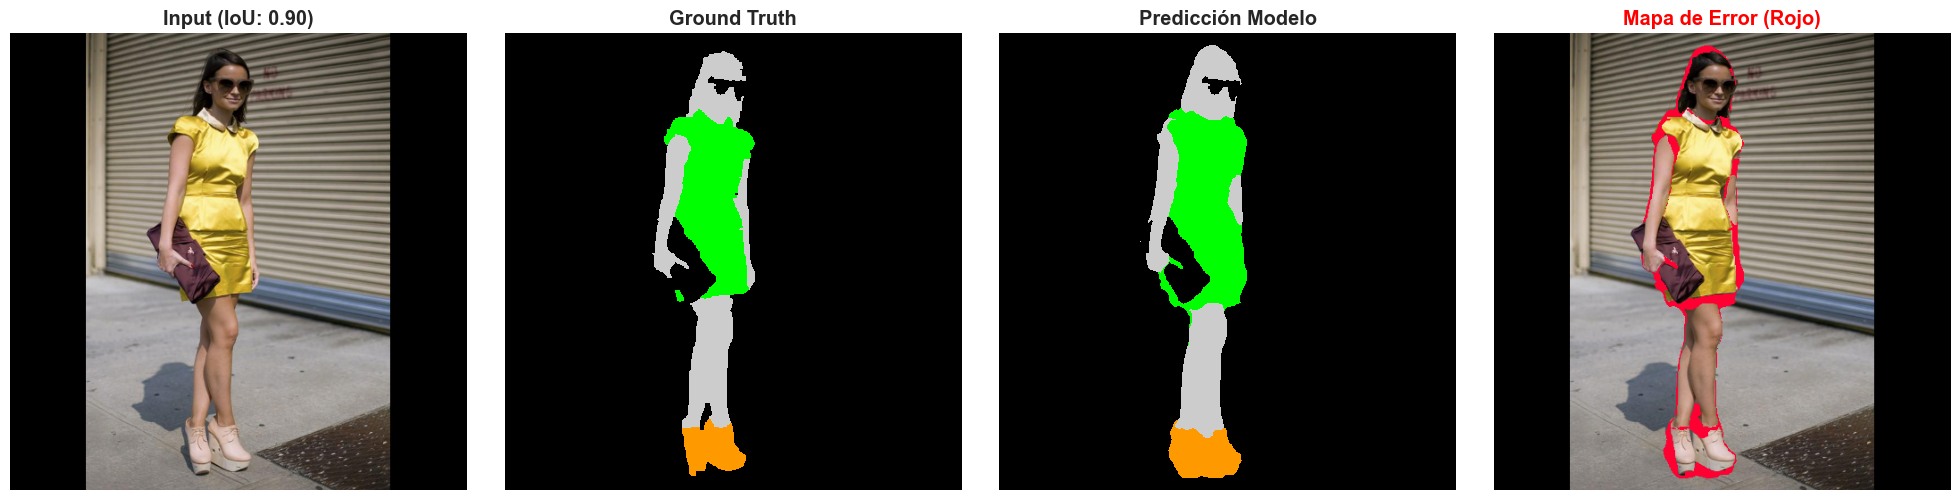

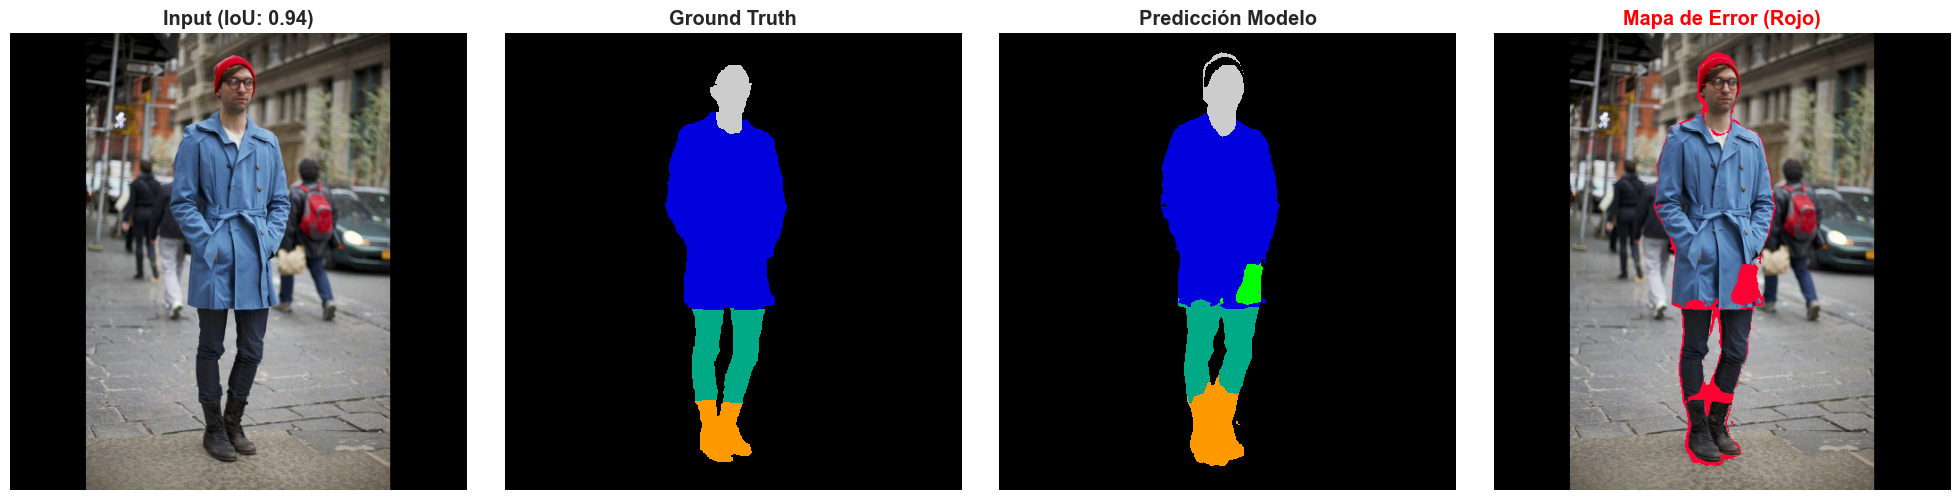

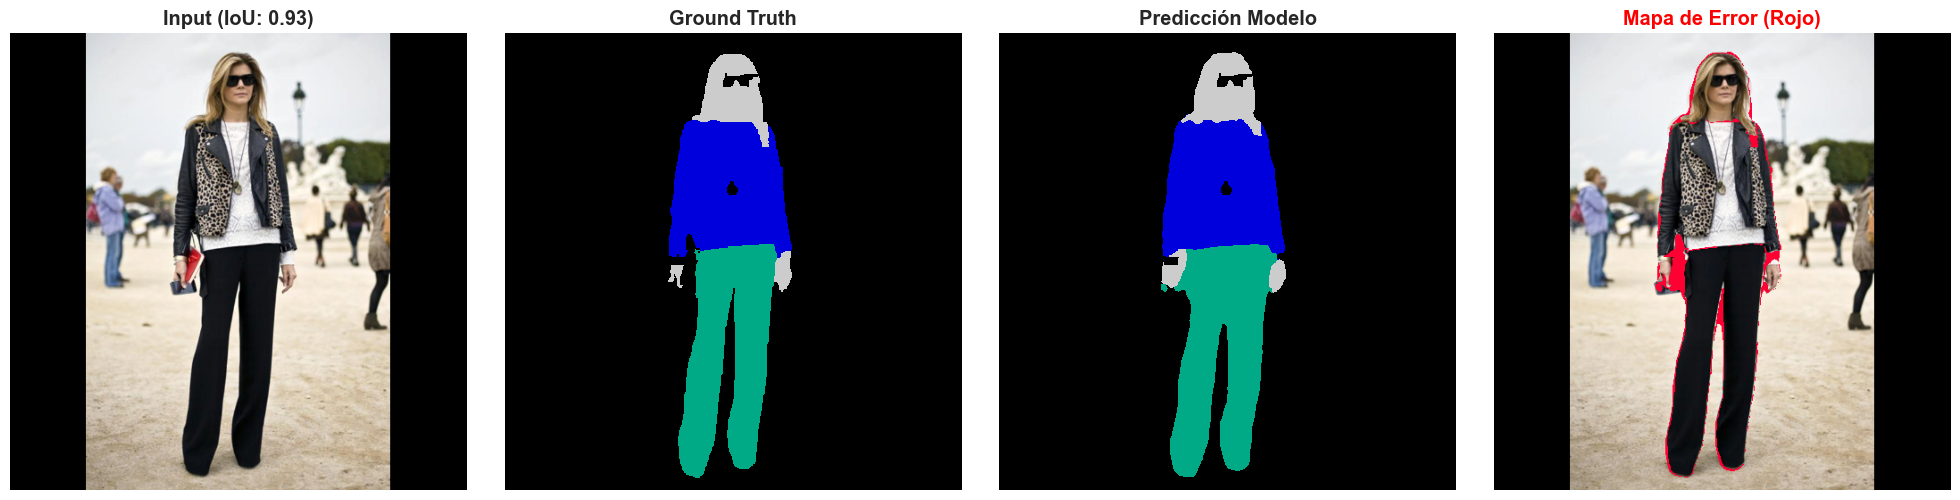

In [31]:


def visualize_error_map_pro(image, gt, pred, iou_score):
    """
    Visualiza Imagen, GT, Predicción y Mapa de Error.
    Args:
        image: (H,W,3) uint8
        gt, pred: (H,W) long
        iou_score: float (IoU de esta imagen específica)
    """
    # Crear máscara de error (Donde pred != gt)
    error = (gt != pred)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Imagen Original
    axes[0].imshow(image)
    axes[0].set_title(f"Input (IoU: {iou_score:.2f})", fontweight='bold')
    axes[0].axis("off")

    # 2. Ground Truth
    axes[1].imshow(gt, cmap='nipy_spectral', interpolation='nearest')
    axes[1].set_title("Ground Truth", fontweight='bold')
    axes[1].axis("off")

    # 3. Predicción
    axes[2].imshow(pred, cmap='nipy_spectral', interpolation='nearest')
    axes[2].set_title("Predicción Modelo", fontweight='bold')
    axes[2].axis("off")

    # 4. Errores Superpuestos
    # Mostramos la imagen en escala de grises de fondo para resaltar el rojo
    overlay = image.copy()
    # Pintamos de rojo radioctivo [255, 0, 50] los errores
    overlay[error] = [255, 0, 50]

    axes[3].imshow(overlay)
    axes[3].set_title("Mapa de Error (Rojo)", fontweight='bold', color='red')
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

def run_error_analysis(model, dataloader, device="cuda", n_samples=3, ignore_index=255):
    """
    Ejecuta el análisis de errores en varias muestras aleatorias.
    """
    model.eval()

    # Iterador
    data_iter = iter(dataloader)

    # Stats de ImageNet para des-normalizar correctamente
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    print(f" ANALIZANDO {n_samples} MUESTRAS DEL SET DE VALIDACIÓN/TEST...")

    count = 0
    with torch.no_grad():
        for images, gts in data_iter:
            images = images.to(device)
            gts = gts.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Procesar batch
            for i in range(images.shape[0]):
                if count >= n_samples: return

                # --- Procesar Imagen ---
                img_tensor = images[i].cpu()
                # Des-normalizar matemáticamente correcto
                img_tensor = img_tensor * std + mean
                img_tensor = torch.clamp(img_tensor * 255, 0, 255).byte()
                img_np = img_tensor.permute(1, 2, 0).numpy()

                # --- Procesar Máscaras ---
                gt_np = gts[i].cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                # Manejar ignore index (lo convertimos a 0-Background para visualizar)
                mask_ignore = (gt_np == ignore_index)
                gt_np[mask_ignore] = 0
                pred_np[mask_ignore] = 0 # Ignoramos errores en zonas ignore

                # --- Calcular IoU de esta imagen individual ---
                intersection = np.logical_and(gt_np, pred_np).sum()
                union = np.logical_or(gt_np, pred_np).sum()
                iou = intersection / (union + 1e-6)

                # Visualizar
                visualize_error_map_pro(img_np, gt_np, pred_np, iou)

                count += 1

# EJECUCIÓN FINAL
run_error_analysis(
    model=model,
    dataloader=val_dl, # O test_dl
    device="cpu",
    n_samples=3  # Veremos 3 ejemplos distintos
)

In [32]:

import matplotlib.patches as mpatches
import cv2

# ==============================================================================
# 1. CONFIGURACIÓN GLOBAL DE COLORES (LA FUENTE DE LA VERDAD)
# ==============================================================================
# Definimos esto primero para que esté disponible globalmente
SEGMENTATION_CONFIG = {
    0:   ("background", (0, 0, 0)),       # Negro
    1:   ("topwear",    (220, 20, 60)),   # Crimson (Rojo Intenso)
    2:   ("lowerwear",  (30, 144, 255)),  # DodgerBlue (Azul)
    3:   ("dress",      (255, 165, 0)),   # Orange (Naranja)
    4:   ("footwear",   (148, 0, 211)),   # DarkViolet (Violeta Oscuro)
    5:   ("body",       (46, 139, 87)),   # SeaGreen (Verde)
    255: ("ignore",     (64, 64, 64))     # Gris para ignore
}

# ==============================================================================
# 2. MOTOR DE INFERENCIA PROFESIONAL
# ==============================================================================

@torch.no_grad()
def predict_from_image(
    model,
    image_path,
    transform,
    device,
    dataset_info,
    figsize=(18, 6),
    alpha=0.5
):
    """
    Realiza inferencia, visualización 'Pro' y reporte estadístico.
    Retorna: pred_mask, detected_classes, img_np_original
    """
    model.eval()

    # --- A. Cargar Imagen ---
    try:
        img_pil = Image.open(image_path).convert("RGB")
        img_np_original = np.array(img_pil)
    except Exception as e:
        print(f" Error cargando imagen {image_path}: {e}")
        return None, [], None

    original_h, original_w = img_np_original.shape[:2]

    # --- B. Preprocesamiento ---
    try:
        # Usamos la transformación (generalmente val_tf: Resize + Normalize)
        augmented = transform(image=img_np_original)
        img_tensor = augmented["image"].unsqueeze(0).to(device)
    except Exception as e:
        print(f" Error en transformación: {e}")
        return None, [], None

    # --- C. Inferencia ---
    #
    logits = model(img_tensor)
    pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

    # --- D. Resize Inteligente (Back to Original Size) ---
    # Es vital usar INTER_NEAREST para que los IDs de clase (0,1,2...) no se interpolen
    if (original_h, original_w) != pred_mask.shape:
        pred_mask = cv2.resize(
            pred_mask.astype(np.uint8),
            (original_w, original_h),
            interpolation=cv2.INTER_NEAREST
        )

    # --- E. Coloreado (Usando SEGMENTATION_CONFIG) ---
    h, w = pred_mask.shape
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)

    # Pintamos usando la configuración global
    for idx, (name, color) in SEGMENTATION_CONFIG.items():
        mask_rgb[pred_mask == idx] = color

    # --- F. Overlay (Superposición) ---
    # cv2.addWeighted requiere arrays del mismo tipo
    overlay = cv2.addWeighted(img_np_original, 1-alpha, mask_rgb, alpha, 0)

    # --- G. Análisis de Clases Detectadas ---
    unique_classes = np.unique(pred_mask)
    detected_classes = [c for c in unique_classes if c != 255] # Ignoramos 255

    # Recuperar nombres usando dataset_info
    idx_to_label = dataset_info.get('idx_to_label', {})
    class_names_found = []

    for c in detected_classes:
        name = idx_to_label.get(c, SEGMENTATION_CONFIG.get(c, ("Unknown",))[0])
        class_names_found.append(name)

    # ==========================================
    # VISUALIZACIÓN (Matplotlib)
    # ==========================================
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # 1. Original
    axes[0].imshow(img_np_original)
    axes[0].set_title(f"Imagen Original\n({original_w}x{original_h})", fontweight='bold')
    axes[0].axis('off')

    # 2. Máscara (Color)
    axes[1].imshow(mask_rgb)
    axes[1].set_title("Segmentación Pura", fontweight='bold')
    axes[1].axis('off')

    # 3. Overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f"Superposición (α={alpha})", fontweight='bold')
    axes[2].axis('off')

    # Leyenda Dinámica
    patches = []
    for c, name in zip(detected_classes, class_names_found):
        # Normalizamos color a [0,1] para matplotlib
        color_norm = np.array(SEGMENTATION_CONFIG[c][1]) / 255.0
        patches.append(mpatches.Patch(color=color_norm, label=f"{c}: {name}"))

    if patches:
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Clases Detectadas")

    plt.tight_layout()
    plt.show()

    # ==========================================
    # REPORTE DE TEXTO (Estadísticas)
    # ==========================================
    print("\n" + "="*50)
    print(f" REPORTE DE INFERENCIA: {image_path.split('/')[-1]}")
    print("="*50)
    print(f"{'ID':<5} | {'CLASE':<15} | {'PÍXELES':<12} | {'% ÁREA':<10}")
    print("-" * 50)

    total_pixels = pred_mask.size

    for c, name in zip(detected_classes, class_names_found):
        count = (pred_mask == c).sum()
        pct = (count / total_pixels) * 100
        print(f"{c:<5} | {name:<15} | {count:<12,} | {pct:<6.2f}%")
    print("="*50 + "\n")

    return pred_mask, detected_classes, img_np_original

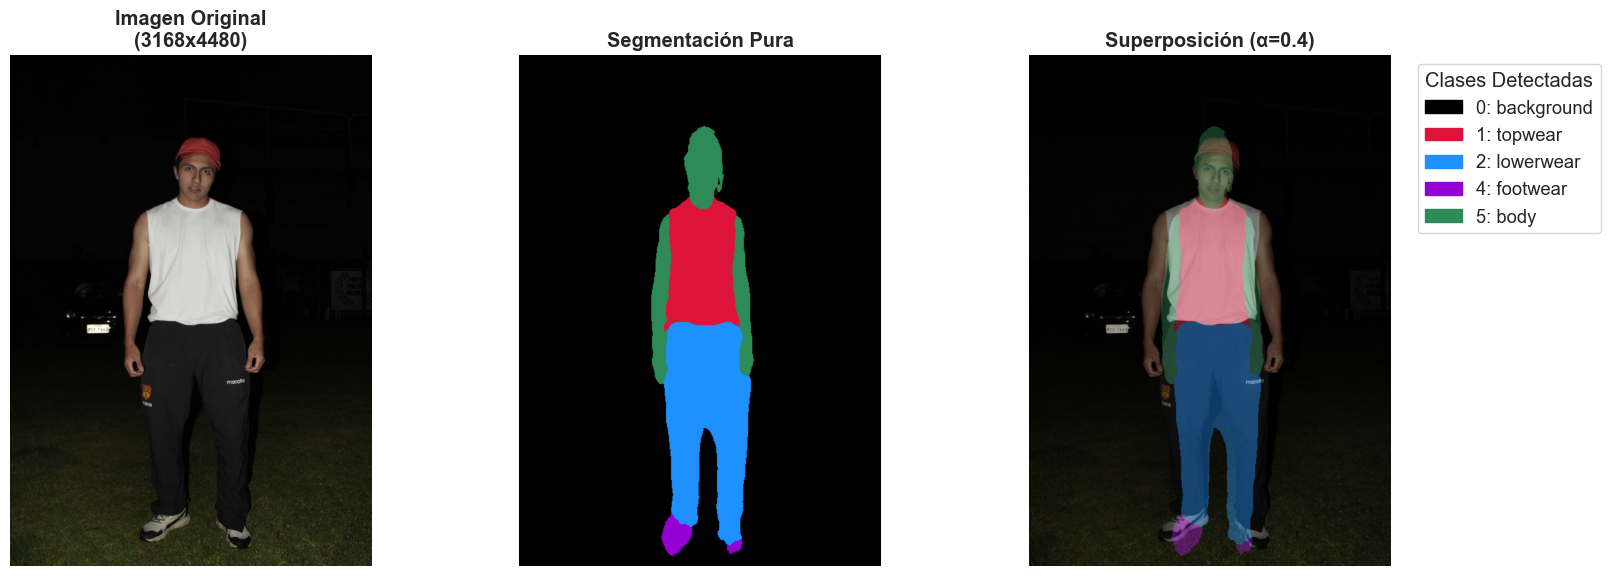


 REPORTE DE INFERENCIA: C:\Users\pc\Desktop\Proyecto_Segmentacion\Imagen_eval\vialpando.png
ID    | CLASE           | PÍXELES      | % ÁREA    
--------------------------------------------------
0     | background      | 11,942,203   | 84.14 %
1     | topwear         | 601,123      | 4.24  %
2     | lowerwear       | 1,075,989    | 7.58  %
4     | footwear        | 72,161       | 0.51  %
5     | body            | 501,164      | 3.53  %



In [36]:
image_path = "C:\\Users\\pc\\Desktop\\Proyecto_Segmentacion\\Imagen_eval\\vialpando.png"
# O usa: image_path = "vialpando.png"

import os
if os.path.exists(image_path):
    # La llamada es limpia y simple
    mask, classes, img = predict_from_image(
        model=model,
        image_path=image_path,
        transform=val_tf,      # Usamos val_tf
        device="cuda" if torch.cuda.is_available() else "cpu",
        dataset_info=info,     # Tu diccionario info
        alpha=0.4
    )
else:
    print(" Archivo no encontrado.")

# SEPARACION DE PRENDAS Y COLOR